<figure>
  <IMG SRC="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" WIDTH=250 ALIGN="right">
</figure>

# CIE5314 Flood defences 
### Exercise April 2020
*Developed: HKV

## 1	Import
In chapter 2 starts the exercise description, in this chapter data en functions to be used in the exercise are imported. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openturns as ot #run pip install openturns in the cmd kernal
from scipy.interpolate import interp1d
from scipy import stats as st
from scipy import special
from scipy.stats import lognorm
%matplotlib inline

### 1.1 Import data

In [2]:
data_loc = "C:/Users/jschl/Desktop/AssignmentFD/" #You have to change this to the data folder
cross_sections=pd.read_excel(data_loc+'cross_sections.xlsx')
wind=pd.read_excel(data_loc+'wind.xlsx')
wind_exceedence=pd.read_excel(data_loc+'Exceedence_probability_wind_velocity.xlsx',index_col=0)
waterlevel_CDF=np.loadtxt(data_loc+'Cumulative_density_function_water_level.txt')

### 1.1 Import functions

In [3]:
def plot_cross_sections (name,create_fig=False, create_legend=False):
    if create_fig:
        plt.figure(figsize=(15,5))
        plt.grid()
        plt.xlabel('Distance [m]',fontsize=16)
        plt.ylabel('Surface level [m + NAP]',fontsize=16)
    plt.plot(cross_sections[name+', x'],cross_sections[name+', z'], label='cross section: '+name)
    if create_legend:
        plt.legend(fontsize=12)

def CDF_to_PDF_to_distribution(CDF,N,delta=0.01,plot_cdf=True,plot_pdf=True,legend=True):
    cdf_x=CDF[:,0]
    cdf_y=CDF[:,1] 
    x_hist=np.arange(np.min(cdf_x),np.max(cdf_x),delta)
    func_hist=interp1d(cdf_x,cdf_y)
    y_hist_cdf=func_hist(x_hist)
    y_hist_pdf=(y_hist_cdf[1::]-y_hist_cdf[0:-1])/(x_hist[1::]-x_hist[0:-1])
    hist_dist=st.rv_histogram((y_hist_pdf,x_hist))
    if plot_cdf:
        plt.plot(x_hist,hist_dist.cdf(x_hist),label='CDF')
    if plot_pdf:
        plt.plot(x_hist,hist_dist.pdf(x_hist), label='PDF')
    if legend:
        plt.legend()
        plt.xlabel('Waterlevel')
        plt.title('Distribution based on data')
    return hist_dist.ppf(np.random.random(N))

### 1.2 Example probabilistic calculation in Python using the OpenTurns module

In [4]:
N=1000 #sample size
x= ot.Sample(N,1)  #uses a dataset

for i in range(N):
    x[i,0]=CDF_to_PDF_to_distribution(waterlevel_CDF,N=1,delta=0.01,plot_cdf=False,plot_pdf=False,legend=False)[0]
    
x_dis=ot.UserDefined(x,[1/N]*N) # distribution based on dataset
a_dis=ot.Normal(20,10) # normal distribution with mean=20, standarddeviation=10
b_dis=ot.LogNormalMuSigma(10,300).getDistribution() # lognormal distributionm with mean=10 and standarddeviation=300

# Z function
def example_Z_function(X):
    x,a,b=X
    Z=a*x**2-b
    return [Z]

# Create the event you want to estimate the probability
marginals=[x_dis,a_dis,b_dis]
description=['x','a','b']
Z=ot.PythonFunction(len(marginals),1,example_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(100000)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

#run Form
startvalues=distribution.getMean()
startvalues[0]=7 #Let the waterlevel start at for example 7
algo = ot.FORM(optimAlgo, event, distribution.getMean())
algo.run()
result = algo.getResult()
print ('Form probability:',round(result.getEventProbability(),2))

#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(N))
algo.run()
result=algo.getResult()

print ('Montecarlo probability',round(result.getProbabilityEstimate(),2 ))

Form probability: 0.02
Montecarlo probability 0.02


---
## 2	Exercise description
### 2.1	Introduction
In this exercise you are tasked to carry out a safety assessment and, subsequently, design of reinforcement measures for the failure mechanisms overtopping, piping and slope stability for a levee section at Water Authority Rivierenland.

Based on Dutch legislation, the safety standards of primary flood defences in the Netherlands must be assessed every 12 years. When the safety standard does not meet the requirements, reinforcement must be prepared and implemented. The rules, standards and methods for flood defence assessments and designs are noted in the `Wettelijk beoordelingsinstrumentarium 2017 (WBI2017)` and `Ontwerpinstrumentarium (OI2014v4)`. 

### 2.2	Scope
The levee trajectory of interest is situated along the Lek from Amsterdam-Rijnkanaal to Fort Everdingen with a total length of 15.86 kilometres as shown in Figure 1. You are going to assess a 280 m section of the levee: section BF095.50 – BF098.30. This levee section is part of levee trajectory (dijktraject) 43-1. 

<img src="Figure1.png"  width="500"/>

 
<center>  <i> Figure 1: Location of dike stretch 43-1 </i> </center>

The investigated levee section is located North West of Culemborg. Figure 2 shows an aerial photo of this section. Figure 3 shows a Street View photo, where you can see the distance between the levee and the houses. The representative cross-sections of this section are presented in Figure 4. These sections are derived from the elevation map, which is shown in Figure 5. 
 
<img src="Figure2.png"  width="500"/>

<center>  <i> Figure 2: Investigated part of the dike; dike section BF095.50 – BF098.30 </i> </center>

<img src="Figure3.png"  width="500"/>
 
<center>  <i> Figure 3: Google Maps Street view picture taken from the crest of the dike of interest ({Hyperlink: "www.google.nl/maps"}, October 2015) </i> </center>

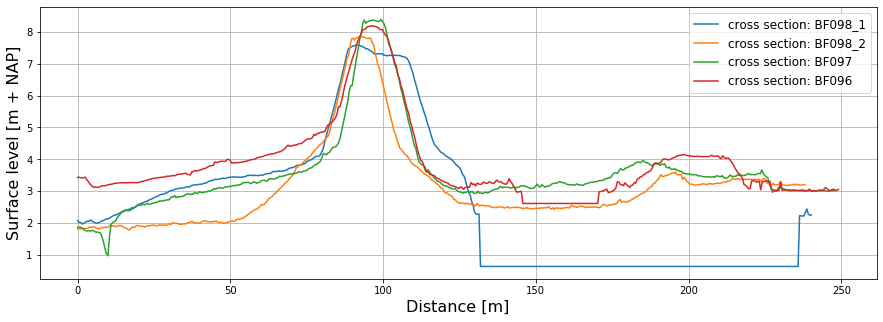

In [5]:
plot_cross_sections ('BF098_1',create_fig=True)
plot_cross_sections ('BF098_2')
plot_cross_sections ('BF097')
plot_cross_sections ('BF096', create_legend=True)

<center>  <i> Figure 4: Different cross-sections of section BF095.50 – BF098.30. The river is located at the right side of the levee. Please note that this figure only shows the surface elevation. Depth of water bodies, like ditches or gullies are not displayed.</i> </center> 

<img src="Figure5.png"  width="500"/>

<center>  <i> Figure 5: Elevation map based on AHN3 (https://ahn.arcgisonline.nl/ahnviewer/). Please note that the depth of water bodies, like ditches or gullies are not displayed in this figure </i> </center>


### 2.3 Safety standard
An acceptable risk level can be determined based on the consequences of a flood at this location. In the event of a levee breach along trajectory 43-1, part of the Betuwe will flood. Based on Dutch legislation, the safety standard of a levee trajectory is based on a basic safety level for each individual person. This safety standard can be more strict based on a cost benefit analysis or societal risk.
 
Each individual in the Netherlands has the right to live in a place where flood safety meets at least the basic safety level. Additionally, this safety level can be increased when the area is of importance for economy, cultural heritage or when large groups of people can be exposed.

For the basic safety level, the risk of loss of life is expressed as: the local individual risk (LIR). The LIR describes the annual probability for a person to die in the area as a result of a flood. In the Netherlands an upper limit of this risk level has been set, which is called basic safety. For the Netherlands this basic safety level has been set at 1/100.000 per year. The LIR must, by law, at least be lower.

Given the consequences of a flood, the mortality and the degree of evacuation; the flood probability for this flood defence can be determined in order to meet the basic safety level of 1/100.000 per year.  

A consequence of a breach for trajectory 43-1 is shown in Figure 6. 

<img src="Figure6.png"  width="500"/> 
 
<center>  <i> Figure 6: Consequence dike breach for trajectory 43-1 </i> </center>

The calculation of the LIR is a combination of the probability of a flood, the mortality (probability of loss of life given the flood characteristics) and the degree of evacuation. 

$ LIR= P_{flood}×Mortality×(1-degree\_of\_evacuation) $

To ensure that the entire area meets the basic safety level (LIR of less than 1/100.000 per year); the most vulnerable part of this area must be considered. The Figure above shows an area north of the regional river Linge. When a levee breach occurs, the average water depth in this area is approximately 4.5 meters. 

Based on this water depth, the mortality can be calculated. 

Mortality: $F_D (h)= Փ_N (\frac{ln⁡(h)- μ_N}{σ_N});$
$μ_N=7.60$ and
$σ_N=2.75 $

The degree of evacuation for this area has been set at 55 percent. This means that in the event of a possible flood, 55 percent of the inhabitants can be evacuated preventively.

At this location other levee trajectories might flood the same area as well. Additionally, given this, and an executed cost-benefit analysis; the safety standard for trajectory 43-1 is set to a failure probability of $P = 1/10.000$ per year. 


### 2.4	Load and strength
In the exercise the three most important failure mechanisms for this location are elaborated on: overtopping and overflow, internal erosion and stability. For these failure mechanisms you are asked to carry out a safety assessment and a dike design; this chapter gives the input information. Information on the load and strength parameters must be used in this exercise. Read this chapter carefully.  


#### 2.4.1 Critical overtopping discharge

In a semi-probabilistic calculation for overtopping and overflow, the overtopping discharge has to be calculated with the loads (water level and wind) corresponding with the safety level of the dike cross-section for the mechanism. This overtopping discharge must be compared with the maximum allowed overtopping discharge. When the calculated discharge is lower than the maximum allowed overtopping discharge, the levee meets the required safety standard. The maximum allowed overtopping and overflow discharge depends on the wave height and revetment quality. The critical discharge is lognormal distributed with the parameters given in Table 4. 

---

<center>  <i> Table 1: Mean and standard deviation for the critical discharge for different wave height and divot qualities </i> </center>

||Closed  |divot|Open |divot|
|------|------|------|------|------|
|Wave height |μ [l/s/m]|	σ [l/s/m]|	μ [l/s/m]|	σ [l/s/m]|
|0 – 1 m| 	225|	250	|100	|120|
|1 – 2 m|	100|	120	|70	|80|
|2 – 3 m |	70	|80	|40	|50|


#### 2.4.2 Hydraulic load parameters
Hydraulic load is the driving force which can lead to levee failure. The exceedance frequency of the water levels is therefore very important. The exceedance frequency line of the water levels for the levee section that must be assessed is given in Figure 7 and came from Hydra-NL. Hydra-NL is a probabilistic model and calculates the hydraulic load statistics (water level, waves and overtopping) and integrates uncertainty about the median estimate. The water level corresponding with an exceedance probability of 1/10,000 per year is 7.35 m + NAP. And for an exceedance probability of 1/41.667 per year the water level is 7.56 m + NAP. The cumulative density function of the water level corresponding with the frequency line is attached in the file `Cumulative_density_function_water_level.xpt`. 

<img src="Figure7.png"  width="500"/>
<center>  <i> Figure 7: Frequency line of the river water level</i> </center>

In addition to the water level, the wind is an important load parameter. The wind characteristics are divided into 16 wind directions. The wind velocity and fetch data per direction with an exceedance probability of 1/ 41,667 per year are shown in Table 1. The exceedance probability per wind velocity per direction is given in the file `Exceedence_probability_wind_velocity.xlsx`. 

---
 
<center>  <i> Table 2: Wind and fetch data with an exceedance probability of 1/41667 per year</i> </center>

In [6]:
wind

,direction[deg],direction,Effective Fetch[m],Wind speed at an altitude of 10 m [m/s],P(occurrence) [%],Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,22.5,NNE,2392.0,22.8,6.4,NaN,10.5,0.000021,0.999979,1.323520e-06,3.176423e-11
1,45.0,NE,3128.0,23.4,10.4,NaN,33.0,0.000017,0.999983,1.791920e-06,4.300574e-11
2,67.5,ENE,3480.0,22.8,14.5,NaN,55.5,0.000023,0.999977,3.371250e-06,8.090935e-11
3,90.0,ENE,2992.0,22.2,10.3,NaN,78.0,0.000020,0.999980,2.074420e-06,4.978568e-11
4,112.5,ESE,1622.0,21.0,1.9,NaN,100.5,0.000017,0.999983,3.142600e-07,7.542180e-12
5,135.0,SE,738.0,21.0,2.3,NaN,123.0,0.000017,0.999983,NaN,NaN
6,157.5,SSE,240.0,22.8,2.2,NaN,145.5,0.000023,0.999977,NaN,NaN
7,180.0,S,120.0,24.6,2.8,NaN,168.0,0.000022,0.999978,NaN,NaN
8,202.5,SSW,120.0,27.6,4.5,NaN,190.5,0.000021,0.999979,NaN,NaN
9,225.0,SW,176.0,33.0,4.9,NaN,213.0,0.000022,0.999978,NaN,NaN


The wave height and period can be calculated from the provided water depths and wind data. Reference is made to the Hydraulic `Structures Manual (CTB3355)`, which can be found on Brightspace under Readings. Please use the `Young and Verhagen formula`. Formulas concerning the mean and maximum overtopping discharge can be found in the lecture notes of this course. When the water level is higher than the crest of the dike, the part of overflowing water can be calculated by:  

$q_{overflow}=0.54 \sqrt{g|R_c^3 |}$        
$R_c<0$	

In which: <br/>
$R_c$ = Freeboard $(h_{crest}-h)$

#### 2.4.3 Geotechnical parameters

<img src="Figure8.png"  width="200"/>


<center>  <i> Figure 8: Soil boring at toe of the dike with depth in m +NAP (left overview and right detail) </i> </center>

<center>  <i> Table 3: Mean geotechnical parameters of the soil boring </i> </center>

|Colour|	Material|	Saturated volumetric weight [kN/m³]|	Dry Volumetric weight[kN/m³]|	Cohesion [kN/m²]|	Friction angle [deg]	|Undrained shear strength ratio [-]|	Strength increase exponent [-]	|POP top [kN/m²]|	POP bottom [kN/m²]|
|:------|------|------|------|------|------|------|------|------|------|
| <font color='purple'>purple</font>|Clay (dike material)	|18.00 	|18.00	|0.01|	32	|0.31|	0.90	|30	|30|
|<font color='green'>green</font>|	Peat|	14.50|	14.50|	0.01|	30|	0.29|	0.90|	24|	24|
|<font color='pink'>pink</font>|	Clay	|15.00	|15.00|	0.01|	30	|0.29|	0.90|	24	|24|
|<font color='orange'>orange</font>|	Sand	|18.00	|20.00|	0	|34	|-|	-|	-	|-|

#### 2.4.4 Parameters and their distributions
Some geometry and geotechnical parameters and their distributions are provided in Table 4, make reasonable assumption for the remaining ones. For the roughness coefficient assume the entire revetment is covered with a grass layer. The geotechnical length profile is given in the files ‘Geotechnical_length_profile.tif’.  The dike consists completely out of clay and the result of the representative soil boring is shown in Figure 8 and Table 3. The boring is taken close to the levee. More detailed information about the geotechnical parameters are shown in ‘Geotechnical_data.xlsx’. 

---
<center>  <i> Table 4: Geometry and geotechnical parameters (*these parameters need to be estimated from the available graphs and pictures, or from other sources (DINO database, Google Earth, etc.)) </i> </center>

|    Parameters    |    Distribution    |    Mean    |    Standard   deviation  or Coefficient of variation     |
|:------|:------|:------|:------|
|70%-fractile of   grain size distribution [m]    |    Lognormal    |    2.8e-4    |  $V=0.12$      |
|Angle normal to dike [deg]    |    Deterministic    |    12    |    -    |
|    Aquifer thickness   [m]    |    Lognormal    |    25     |    $\sigma=0.5$       |
|    Bedding angle [deg]    |    Deterministic    |    37    |    -    |
|    Bottom level [m +   NAP]    |    Normal    |    2.35    |   $\sigma=0.3$      |
|    Cohesion [kN/m²]     |    Lognormal    |    See table 3    |  $V=0.0001$      |
|    Constant of White   [-]    |    Deterministic    |    0.25    |    -    |
|    Critical heave   gradient [-]    |    Lognormal    |    0.5    |  $\sigma=0.1$       |
|    Dike height [m]    |    Deterministic    |    Estimate    |    -    |
|    Fetch length [m]    |    Deterministic    |    See table 2   |    -    |
|    Friciton Angle [deg]    |    Lognormal    |    See table 3    | $V=0.000333$ & $ V =0.1$ (for dike material) |
|    Gravitational   constant [m/s²]    |    Deterministic    |    9.81    |    -    |
|    Hinterland phreatic   level [m + NAP]    |    Normal    |    3.5     | $\sigma=0.1$        |
|    Hydraulic   conductivity aquifer [m/s]    |    Lognormal    |    7.52e-4    | $V=0.50$      |
|    Hydraulic   conductivity aquitard [m/s]    |    Lognormal    |    1.00e-6    |    $V=0.50$    |
|Intrusion length [m]| Deterministic|1.0|-|
|    Kinematic viscosity   [m²/s]    |    Deterministic    |        |    -    |
|    Length (effective)   foreshore [m]    |    Lognormal    |    20     |     $V=0.1$   |
|    Model factor piping   [-]    |    Normal    |    1.0    | $\sigma=0.12$        |
|    Model factor uplift   [-]    |    Normal    |    1.0    |   $\sigma=0.1$      |
|    POP    |    Lognormal    |         |     $V=0.30$ & $ V =0.45$ (for dike material)      |
|    Reference value of   70%-fractile of grain size distribution [m]    |    Deterministic    |    2.08e-4    |    -    |
|    Saturated   volumetric weight blanket [kN/m³]    |    Normal    |    Estimate      |    $V=0.05$    |
|    Slope     |    Deterministic    |    Estimate   |    -    |
|    Slope width [m]    |    Deterministic    |    Estimate   |    -    |
|    Strength increase component [-]    |    Lognormal    |    See table 4    |           $V=0.033$ |
|    Thickness   hinterland blanket [m]    |    Lognormal    |    Estimate   |       $\sigma=0.5$  |
|    Undrained shear strength ratio    |    Lognormal    |    See table 3    |         $V=0.207$ & $ V =0.199$ (for dike material)  |
|    Volumetric weight   sand grains [kN/m³]    |    Deterministic    |    16.5    |    -    |
|    Volumetric weight   water [kN/m³    |    Deterministic    |    10    |    -    |
|    Width levee [m]    |    Deterministic    |    Estimate     |    -    |


For a semi-probabilistic assessment, one should keep the 5% and 95% conﬁdence intervals in mind. In the safety assessment the confidence intervals for a lognormal distribution are calculated with the formulas given below:

$ X_{lower} =\exp{⁡( μ_m-t_{n-1} σ_m  \sqrt{(1-a)+1/n)})}$   and    $X_{upper}=\exp{⁡(μ_m+t_{n-1} σ_m  \sqrt{((1-a)+1/n))}}$

$σ_m^2=\ln⁡{[1+(σ_X/μ_X )^2]}$
$μ_m=\ln{[μ_X] }-1/2 σ_m^2$

In which:<br/>
$X$ = Confidence bounds<br/>
$μ_X$=	Mean value <br/>
$μ_m$=	Mean value of a logarithm <br/>
$t_{n-1}$=	Student t-factor corresponding with the coincidence bound (take $t_{n-1}$=1.76)<br/>
$σ_X$=	Standard deviation<br/>
$σ_m$=	Standard deviation of a logarithm <br/>
$a$=	Ratio between the local and regional variation (takea=0)<br/>
$n$=	Number of observations (taken=15) <br/>


#### 2.4.5	Slope stability
The failure mechanism slope stability is analysed qualitatively later on this exercise. In the semi-probabilistic safety assessment, the water level corresponding with the safety level (1/10,000 per year) has to be used. The safety factor for slope stability can be calculated with the software D-Stability. Some results of the calculation are shown in the figures below. Note that the same stability calculation is discussed in class. To see the influence of a design choice on the safety factor, you are free to use the discussed exercise. 

 <img src="Figure9.png"  width="500"/>
<center>  <i> Figure 9: Safety factor for inner slope stability = 0.97 </i> </center>

  <img src="Figure10.png"  width="500"/>
<center>  <i> Figure 10: Safety factor for inner slope stability = 1.06 </i> </center>
 
 <img src="Figure11.png"  width="500"/>
<center>  <i> Figure 11: Safety factor for inner slope stability = 1.10 </i> </center>

  <img src="Figure12.png"  width="500"/>
<center>  <i> Figure 12: Safety factor for inner slope stability = 1.28 </i> </center>

### 2.5 Calibration formula’s
With the use of calibration formulas safety factors can be transformed into failure probabilities for the failure mechanisms uplift, heave, piping and slope stability. The calibration formulas are given below:

Calibration formula uplifting:
$P_{f;u}=ϕ[-\frac{\ln⁡{(F_u/0.48)}+0.27β_{req})}{0.46}]$

Calibration formula heave:
$P_{f;h}=ϕ[-\frac{\ln⁡{(F_h/0.37)}+0.3 β_{req})}{0.48}]$

Calibration formula piping:
$P_{f;p}=ϕ[-\frac{\ln⁡{(F_p/1.04)}+0.43 β_{req})}{0.37}]$

Calibration formula slope stability:
$P_{f;i}=ϕ[-\frac{(F_{d,i}/γ_d )-0.41}{0.15}]$

In which:<br/>
$P_{f;j}$ =	The failure probability of the failure mechanism j [1/year]<br/>
$F$ =	Safety factor of the failure mechanism [-]<br/>
$γ_d$ =	Model factor, take γ_d=1.06  [-]<br/>
$β_{req}$ =	The reliability index for the dike segment [-]<br/>

## 3 Questions
### 3.1 Safety assessment
In this exercise you are tasked to carry out a safety assessment for the given dike trajectory.
#### Question 1
What are the relevant load conditions in this area?  

In [7]:
print('left empty on purpose')

left empty on purpose


#### Question 2
Calculate the minimum required flooding probability for this area according to the individual risk. Note: regardless of the value you compute for this question, in the remainder of this exercise the minimum required safety level of this levee trajectory is set to 1/10,000 per year.

In [8]:
print('left empty on purpose')

left empty on purpose


#### Question 3	
Considering the area of interest and the determination of the safety level of 1/10.000 per year. What can be a reason for this high safety standard?

In [9]:
print('left empty on purpose')

left empty on purpose


#### Question 4
Calculate the maximum allowed probability of failure for the failure mechanism slope instability, piping and overtopping.

In [4]:
P_req = 1 * 10 **-4 # Safety requirement

omega_slope = 0.04 # factor describing the contribution to failure
omega_piping = 0.24
omega_overtopping = 0.24

P_req_slope = P_req * omega_slope
P_req_piping = P_req * omega_piping
P_req_overtopping = P_req * omega_overtopping

print('The maximum allowed probability of failure for the failure mechanism slope is:', P_req_slope)
print('The maximum allowed probability of failure for the failure mechanism piping is:', P_req_piping)
print('The maximum allowed probability of failure for the failure mechanism overtopping is:', P_req_overtopping)

beta_req_slope = st.norm.ppf(P_req_slope)
beta_req_piping = st.norm.ppf(P_req_piping)
beta_req_overtopping = st.norm.ppf(P_req_overtopping)


The maximum allowed probability of failure for the failure mechanism slope is: 4.000000000000001e-06
The maximum allowed probability of failure for the failure mechanism piping is: 2.4e-05
The maximum allowed probability of failure for the failure mechanism overtopping is: 2.4e-05


#### Question 5
Calculate the target failure probability for a levee section for the failure mechanisms slope instability, piping and overflow. 

In [10]:
# values taken from Table 10.4 lecture notes (p.179)
a_slope = 0.033 # fraction of the trajectory length, that is sensitive to a certain failure mechanism 
b_slope = 50 # typical independent section for failure mechanism
a_piping = 0.4
b_piping = 300
L_traj = 15860

N_slope = 1 + a_slope / b_slope * L_traj # Length factor
N_piping = 1 + a_piping / b_piping * L_traj
N_overtopping = 1

P_tar_slope = P_req_slope / N_slope
P_tar_piping = P_req_piping / N_piping
P_tar_overtopping = P_req_overtopping / N_overtopping
P_test = 1/10000

print('The target failure probability for a levee section for the failure mechanisms slope is: ', P_tar_slope)
print('The target failure probability for a levee section for the failure mechanisms piping is: ', P_tar_piping)
print('The target failure probability for a levee section for the failure mechanisms overtopping is: ', P_tar_overtopping)

beta_tar_slope = st.norm.ppf(P_tar_slope)
beta_tar_piping = st.norm.ppf(P_tar_piping)
beta_tar_overtopping = st.norm.ppf(P_tar_overtopping)
beta_test = st.norm.ppf(P_test)

print('The reliability index for a levee section for the failure mechanism slope is:', beta_tar_slope)
print('The reliability index for a levee section for the failure mechanism piping is:', beta_tar_piping)
print('The reliability index for a levee section for the failure mechanism overtopping is:', beta_tar_overtopping)
print(beta_test)

The target failure probability for a levee section for the failure mechanisms slope is:  3.4880881788691624e-07
The target failure probability for a levee section for the failure mechanisms piping is:  1.0836845273931366e-06
The target failure probability for a levee section for the failure mechanisms overtopping is:  2.4e-05
The reliability index for a levee section for the failure mechanism slope is: -4.962025695849234
The reliability index for a levee section for the failure mechanism piping is: -4.737157328246689
The reliability index for a levee section for the failure mechanism overtopping is: -4.0651576754425625
-3.7190164854556804


#### Question 6
Comment on the different target failure probabilities per mechanism. State specifically whether the target is higher or lower for each mechanism, how the length-effect is involved, and whether the standard distribution is appropriate for the project site by Culemborg.

In [12]:
print('left empty on purpose')

left empty on purpose


#### Question 7
Which levee cross section is representative for the failure mechanism overtopping an overtopping? Motivate your answer.

In [6]:
### ITERATION PROCESS CHARACTERISTIC SLOPE ###
Hm0max = 1.3 # computed in Q8
w_level_design = 7.56
g = 9.81

o = [0,1,2,3]
slope_it1 = []
xi_it1 =[]
runup_it1 = []

H_dike_max = [7.59, 7.856, 8.396, 8.19] #Dike heights from BF09801 to BF096
L_it1 = [20.69951667,9.069663932,7.947196916,11.48221899] # horizontal distance between point where Z = H_dike_max and where Z = w_level_design - 1.5 * Hm0
L_m10 = 66.42702852 # maximum deepwater wave length, computed in Q8
Berms = [11.07,0,0,0] #length of riverside berm
A_runup = 1.75 #characteristic value for runup equation. taken from Table 5.1 lecture notes (p.96)

for i in o:
    c = (1.5 * Hm0max + (H_dike_max[i] - w_level_design)) / (L_it1[i] - Berms[i])
    slope_it1 = np.append(slope_it1, c)
    c = slope_it1[i] / (Hm0max / L_m10 ) ** 0.5
    xi_it1 = np.append(xi_it1,c)
    c = A_runup * xi_it1[i] * Hm0max
    runup_it1 = np.append(runup_it1, c)
    

print('runup values for the 1st iteration:', runup_it1) 
print(xi_it1)
#since runup values are measured from SWL, they exceed H_dike_max for every crosssection. 
#Thus slope_it1 are the charcteristic slopes.

print('The characteristic slope values for the crossections are', slope_it1)





runup values for the 1st iteration: [3.3438196  4.02717678 5.70097683 3.65406289]
[1.46981081 1.7701876  2.50592388 1.60618149]
The characteristic slope values for the crossections are [0.2056178  0.24763872 0.35056386 0.22469524]


#### Question 8 
Motivate which critical discharge you use in the overtopping and overflow calculation?

In [14]:
print('left empty on purpose')

left empty on purpose


#### Question 9
Calculate the characteristic values with 5% or 95% exceedance probability to be used in the overtopping calculation.

In [1]:
### INPUTS AND ASSUMPTIONS ###

p_dbed = 0.05
mu_bed = 2.35 #m
sigma_bed = 0.3
w_level_design = 7.56

### Calculations ###
d_bed = st.norm.ppf(p_dbed,mu_bed,sigma_bed) #strength parameter (reducing wave height)
d_fetch = w_level_design - d_bed
slope = 0.2056178

### INPUTS AND ASSUMPTIONS ###
u = np.loadtxt(data_loc + 'wind.txt') #0:direction in degree 1:fetch length,2windspeed,3occurrencprobability
h_berm = 7.2 #estimated based on crossection.xls
Rc = H_dike_design - w_level_design # freeboard

### CALCULATIONS ###

u = np.loadtxt(data_loc + 'wind.txt') #0:direction in degree 1:fetch length,2windspeed,3occurrencprobability
H_dike_design = H_dike_max[0]
Berm = Berms[0]
h_berm = 7.2 #estimated based on crossection.xls
slope = slope_it1[0]
Rc = H_dike_design - w_level_design # freeboard
d_berm = h_berm - w_level_design 

## Already introduced values
#w_level_design = 7.56
#Berms = [11.07,0,0,0]
#slope_it1 = [0.2056178  0.24763872 0.35056386 0.22469524]

print("characteristic value of d_bed is", d_bed)
print("characteristic value of d_fetch is", d_fetch)

NameError: name 'st' is not defined

In [8]:
### WAVE CHARACTERISTICS (BRETTSCHNEIDER EQUATIONS)
m = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15] #number of wind directions

d_tilde = [] # dimensionless fetch depth
F_tilde = [] # dimensionless fetch length
L_m10 = [] #deep water wave length
xi = [] #Irribarren parameter
gamma_T = [] # reduction factor for obliquity for wave period
gamma_H = [] #reduction factor for obliquity for wave height
gamma_q = [] #reduction factor for obliquity for overtopping discharge
gamma_q_grass = [] #reduction factor for grass cover on outer slope
rb = []
rd = []
runup = []
gamma_berm = []

Hs = []
T13 = [] # significant wave period
Tm10 = [] # Tm10 = 0.98 * T13
q = []
q_crit = []
u_corr = []

## Effect of 12deg angle normal to the levee ##
for i in m:
    c = u[i,0] - 12
    u_corr = np.append(u_corr,c)#to take into account the angle normal to dike

## CORRECTION FACTORS ##
u_corr[15] = 360 - 12 

for i in m:
    if u_corr[i] > 180:
        p = 360 - u_corr[i]
    elif u_corr[i] < 180:
        p = u_corr[i]
    if p >= 110:
        c = 0
        d = 1
        gamma_T = np.append(gamma_T,c)
        gamma_H = np.append(gamma_H, c)
        gamma_q = np.append(gamma_q,d)
    elif p < 110:
        if p >= 80:
            c = np.sqrt((110 - p) / 30)
            d = (110 - p) / 30
            e = 1
            gamma_T = np.append(gamma_T,c)
            gamma_H = np.append(gamma_H, d)
            gamma_q = np.append(gamma_q,e)
        elif p < 80:
            c = 1
            gamma_T = np.append(gamma_T,c)
            gamma_H = np.append(gamma_H, c)
            d = 1 - 0.0033 * p
            gamma_q = np.append(gamma_q,d)


## DIMENSIONLESS PARAMETER ##
for i in m:
    c = d_fetch * g / u[i,2] **2
    d_tilde = np.append(d_tilde,c)
    c = u[i,1] * g / u[i,2] **2
    F_tilde = np.append(F_tilde,c)
    c = u[i,2] **2 / g * 0.283 * np.tanh(0.530 * d_tilde[i] **0.75) * np.tanh( 0.0125 * F_tilde[i] **0.42 / np.tanh(0.530 * d_tilde[i] **0.75)) * gamma_H[i]
    Hs = np.append(Hs,c)
    c = u[i,2] / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde[i] ** 0.375) * np.tanh( 0.077 * F_tilde[i] **0.25 / np.tanh(0.833 * d_tilde[i] ** 0.375)) * gamma_T[i]
    T13 = np.append(T13, c)
print('The significant wave heights per direction are')
print(Hs)

## CRITICAL DISCHARGE PER WAVE HEIGHT ##

t_n1 = 1.76
n = 15

mu_q_crit01 = 100
sigma_q_crit01 = 120
sigma_m_q_crit01_squared = np.log(1 + (sigma_q_crit01 / mu_q_crit01)**2)
mu_m_q_crit01 = np.log(mu_q_crit01) - 0.5 * sigma_m_q_crit01_squared

q_crit01_lower= np.exp(mu_m_q_crit01 - t_n1 * np.sqrt(sigma_m_q_crit01_squared) * np.sqrt(1+1/n)) # qcrit is a strength

mu_q_crit21 = 70
sigma_q_crit21 = 80
sigma_m_q_crit21_squared = np.log(1 + (sigma_q_crit21 / mu_q_crit21)**2)
mu_m_q_crit21 = np.log(mu_q_crit21) - 0.5 * sigma_m_q_crit21_squared

q_crit21_lower= np.exp(mu_m_q_crit21 - t_n1 * np.sqrt(sigma_m_q_crit21_squared) * np.sqrt(1+1/n)) #m3/m/s


for i in m:
    if Hs[i]<=1:
        c =  q_crit01_lower
        q_crit = np.append(q_crit,c)
    elif Hs[i]>1:
        c = q_crit21_lower
        q_crit = np.append(q_crit,c)
        
print('The critical overtopping discharge per wind direction is')
print(q_crit)

## IRRIBARREN PARAMETER ##
for i in m:
    if T13[i] == 0:
        c = 0
        xi = np.append(xi,c)
    elif T13[i] != 0:
        c = slope / np.sqrt(Hs[i] /(g * 0.98 * T13[i]**2 / (2 * np.pi)))
        xi = np.append(xi,c)

print("The Irribaren values per wind direction are")
print(xi)

## REDUCTION FACTOR FOR BERM ##
for i in m:
    d = A_runup * xi[i] * Hs [i]
    runup = np.append(runup,d)
    if Hs[i] == 0:
        c = 1
        rb = np.append(rb,c)
        d = 0 
        rd = np.append(rd,d)
    elif Hs[i] != 0:
        Lberm = Hs[i] / slope * 2 + Berm
        c = Berm / Lberm
        rb = np.append(rb,c)
        if runup[i] >= H_dike_design: 
            c =  0.5 - 0.5 * np.cos(np.pi * d_berm / H_dike_design)
            rd = np.append(rd,c)
        elif runup[i] < H_dike_design:
            c =  0.5 - 0.5 * np.cos(np.pi * d_berm / runup[i])
            rd = np.append(rd,c)
    w = 1 - rb[i] * (1 - rd[i])
    if w >= 1:
        c = 1
        gamma_berm = np.append(gamma_berm,c)
    elif w <= 0.6:
        c = 0.6
        gamma_berm = np.append(gamma_berm,c)
    elif w > 0.6:
        gamma_berm = np.append(gamma_berm,w)    
print('The reduction factors due to presence of a berm for different wind direcations are')
print(gamma_berm)

## REDUCTION FACTOR FOR GRASS COVER ##
for i in m:
    if Hs[i] < 0.75:
        c = 1.15 * Hs[i] **0.5
        gamma_q_grass = np.append(gamma_q_grass,c)
    elif Hs[i] >= 0.75:
        c = 1
        gamma_q_grass = np.append(gamma_q_grass,c)
print('The reduction factors due to presence of a grass cover for different wind direcations are')
print(gamma_q_grass)



The significant wave heights per direction are
[0.82432564 0.92123991 0.9276442  0.86240211 0.20970316 0.
 0.         0.         0.         0.         0.         0.33172252
 1.30702665 1.25028208 0.97714731 0.76398362]
The critical overtopping discharge per wind direction is
[11.50076509 11.50076509 11.50076509 11.50076509 11.50076509 11.50076509
 11.50076509 11.50076509 11.50076509 11.50076509 11.50076509 11.50076509
  8.75079616  8.75079616 11.50076509 11.50076509]
The Irribaren values per wind direction are
[0.88393896 0.89265001 0.8974978  0.89268473 0.87582648 0.
 0.         0.         0.         0.         0.         0.86284257
 0.88107936 0.88573902 0.88151808 0.87291548]
The reduction factors due to presence of a berm for different wind direcations are
[0.6        0.6        0.6        0.6        0.97032182 0.6
 0.6        0.6        0.6        0.6        0.6        0.85842246
 0.6        0.6        0.6        0.6       ]
The reduction factors due to presence of a grass cover f

In [9]:
## OVERTOPPING DISCHARGE ACCORDING TO VAN DER MEER AND BRUCE (2014) ## 
    
# Coefficinets for equation 5.11 or 5.12#    
muA11 = 0.023
sigmaA11 = 0.003
muA12 = 0.09
sigmaA12 = 0.013

muB11 = 2.7
sigmaB11 = 0.2
muB12 = 1.5
sigmaB12 = 0.15

A11 = st.norm.ppf(0.95,0.023,0.003)
A12 = st.norm.ppf(0.95,0.09,0.013)

B11 = st.norm.ppf(0.05,2.7,0.2)
B12 = st.norm.ppf(0.05,1.5,0.15)


for i in m:
    if gamma_H[i] == 0:
        c = 0
        q = np.append(q,c)
    elif gamma_H[i] != 0:
        if xi[i] >=2 : #for non-breaking wave regime
            c = A12 * np.sqrt(g * Hs[i] **3) * np.exp(- ((B12 * Rc / (Hs[i] * gamma_q[i] * gamma_q_grass[i])) **1.3))
            q = np.append(q,c)
        elif xi[i] <2 : #for breaking wave regime
            c = A11 / np.sqrt(slope) * np.sqrt(g * Hs[i] **3) * gamma_berm[i] * xi[i] * np.exp(-((B11 * Rc / (xi[i] * gamma_berm[i] * Hs[i] * gamma_q[i] * gamma_q_grass[i]))**1.3))
            q = np.append(q,c)
print('The computed discharges per wind direction for design conditions are [m3/s/m]')    
print(q)

The computed discharges per wind direction for design conditions are [m3/s/m]
[0.06938474 0.08320642 0.08372899 0.07272504 0.00783961 0.
 0.         0.         0.         0.         0.         0.01941571
 0.1410807  0.13342376 0.09019639 0.0603578 ]


#### Question 10: 
Is the safety level requirement for overtopping met with the semi-probabilistic calculation? Support your answer with the results of your calculation.

In [ ]:
print('left empty on purpose')

#### Question 11
Perform a fully probabilistic Monte Carlo calculation for overtopping using a full distribution for the wind speed. It’s recommended to use the `OpenTurns`  module of Python (see paragraph 1.2 for an example) or the `Prob2B` software, provided on Brightspace. You can install the OpenTurns model running the next line in the command prompt: <br/>
`pip install openturns`

To transform the given CDF of the waterlevel to a distribution you may use the given function specified in the begin of the exercise:
`CDF_to_PDF_to_distribution`

In [23]:
## Input
pv_NNE = np.loadtxt(data_loc+'Exceedence_probability_wind_velocity_1.txt', delimiter="\t")
pv_NE = np.loadtxt(data_loc+'Exceedence_probability_wind_velocity_2.txt', delimiter="\t")
pv_ENE = np.loadtxt(data_loc+'Exceedence_probability_wind_velocity_3.txt', delimiter="\t")
pv_E = np.loadtxt(data_loc+'Exceedence_probability_wind_velocity_4.txt', delimiter="\t")
pv_ESE = np.loadtxt(data_loc+'Exceedence_probability_wind_velocity_12.txt', delimiter="\t")
pv_W = np.loadtxt(data_loc+'Exceedence_probability_wind_velocity_13.txt', delimiter="\t")
pv_WNW = np.loadtxt(data_loc+'Exceedence_probability_wind_velocity_14.txt', delimiter="\t")
pv_WN = np.loadtxt(data_loc+'Exceedence_probability_wind_velocity_15.txt', delimiter="\t")
pv_NWN = np.loadtxt(data_loc+'Exceedence_probability_wind_velocity_16.txt', delimiter="\t")
pv_N = np.loadtxt(data_loc+'Exceedence_probability_wind_velocity_test.txt', delimiter="\t")

M = 100000

x= ot.Sample(M,1)  #usses data set of water elevation exceedance
uNNE = ot.Sample(M,1)
uNE = ot.Sample(M,1)
uENE = ot.Sample(M,1)
uE = ot.Sample(M,1)
uESE = ot.Sample(M,1)
uW = ot.Sample(M,1)
uWNW = ot.Sample(M,1)
uWN = ot.Sample(M,1)
uNWN = ot.Sample(M,1)
uN = ot.Sample(M,1)

for i in range(M):
    x[i,0]=CDF_to_PDF_to_distribution(waterlevel_CDF,N=1,delta=0.01,plot_cdf=False,plot_pdf=False,legend=False)[0]
    
for i in range(M):
    uNNE[i,0] = CDF_to_PDF_to_distribution(pv_NNE, N=100, delta = 0.01, plot_cdf=False,plot_pdf=False,legend=False)[0]
    uESE[i,0] = CDF_to_PDF_to_distribution(pv_ESE,N=1,delta=0.01,plot_cdf=False,plot_pdf=False,legend=False)[0]
    uNE[i,0] = CDF_to_PDF_to_distribution(pv_NE, N=100, delta = 0.01, plot_cdf=False,plot_pdf=False,legend=False)[0]    
    uENE[i,0] = CDF_to_PDF_to_distribution(pv_ENE,N=1,delta=0.01,plot_cdf=False,plot_pdf=False,legend=False)[0]
    uE[i,0] = CDF_to_PDF_to_distribution(pv_E,N=1,delta=0.01,plot_cdf=False,plot_pdf=False,legend=False)[0]
    uW[i,0] = CDF_to_PDF_to_distribution(pv_W,N=1,delta=0.01,plot_cdf=False,plot_pdf=False,legend=False)[0]
    uWNW[i,0] = CDF_to_PDF_to_distribution(pv_WNW,N=1,delta=0.01,plot_cdf=False,plot_pdf=False,legend=False)[0]
    uWN[i,0] = CDF_to_PDF_to_distribution(pv_WN,N=1,delta=0.01,plot_cdf=False,plot_pdf=False,legend=False)[0]
    uNWN[i,0] = CDF_to_PDF_to_distribution(pv_NWN,N=1,delta=0.01,plot_cdf=False,plot_pdf=False,legend=False)[0]
    uN[i,0] = CDF_to_PDF_to_distribution(pv_N,N=1,delta=0.01,plot_cdf=False,plot_pdf=False,legend=False)[0]
    
#required wind distributionn

u_disNNE = ot.UserDefined(uNNE, [1/M]*M)
u_disNE = ot.UserDefined(uNE, [1/M]*M)
u_disENE = ot.UserDefined(uENE, [1/M]*M)
u_disUE = ot.UserDefined(uE, [1/M]*M)
u_disESE = ot.UserDefined(uESE, [1/M]*M)
u_disW = ot.UserDefined(uW, [1/M]*M)
u_disWNW = ot.UserDefined(uWNW, [1/M]*M)
u_disWN = ot.UserDefined(uWN, [1/M]*M)
u_disNWN = ot.UserDefined(uNWN, [1/M]*M)
u_disN = ot.UserDefined(uN, [1/M]*M)


x_dis=ot.UserDefined(x,[1/M]*M) #water level

In [ ]:
# ADDITIONAL DISTRIBUTIONS

d_bed_dis = ot.Normal(2.35,0.3)
A11_dis = ot.Normal(0.023,0.003)
A12_dis = ot.Normal(0.09,0.013)
B11_dis = ot.Normal(2.7,0.2)
B12_dis = ot.Normal(1.5,0.15)
q_crit01_lower_dis=ot.LogNormalMuSigma(100,120).getDistribution() # lognormal distributionm with mean=10 and standarddeviation=300
q_crit21_lower_dis=ot.LogNormalMuSigma(70,80).getDistribution() # lognormal distributionm with mean=10 and standarddeviation=300


In [177]:
############################################
### WIND DIRECTION NNE ###

numberofdirection = 0
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_b, gamma_H = gamma_H):
    x,uNNE,A11,A12,B11, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_berm = h_berm - x
    d_fetch = np.max([0.00001,x - d_bed  ])
    u = uNNE
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - B + 11.07) * g / u **2
    
    Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H  
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 1
    elif Hs < 0.75:
        gamma_q_grass = 1.15 * Hs ** 0.5
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disNNE,A11_dis,A12_dis,B11_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uNNE','A11','A12','B11', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

#
#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(M))
algo.run()
result=algo.getResult()

Pf_Mc_overtop = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction NNE', numberofdirection, ':', Pf_Mc_overtop)
#

############################################
### WIND DIRECTION NE ###

numberofdirection = 1
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_b, gamma_H = gamma_H):
    x,uNE,A11,A12,B11, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed  ])
    u = uNE
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - B + 11.07) * g / u **2
    d_berm = h_berm - x
    Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H  
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 1
    elif Hs < 0.75:
        gamma_q_grass = 1.15 * Hs ** 0.5
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    ##computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disNE,A11_dis,A12_dis,B11_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uNE','A11','A12','B11', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)


#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(M))
algo.run()
result=algo.getResult()

Pf_Mc_overtop = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction NE', numberofdirection, ':', Pf_Mc_overtop)
#


############################################
### WIND DIRECTION ENE ###

numberofdirection = 2
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_b, gamma_H = gamma_H):
    x,uENE,A11,A12,B11, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed  ])
    u = uENE
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - B + 11.07) * g / u **2
    d_berm = h_berm - x
    Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H  
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 1
    elif Hs < 0.75:
        gamma_q_grass = 1.15 * Hs ** 0.5
    
     
    
    # ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disENE,A11_dis,A12_dis,B11_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uENE','A11','A12','B11', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)


#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(M))
algo.run()
result=algo.getResult()

Pf_Mc_overtop = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction ENE', numberofdirection, ':', Pf_Mc_overtop)
#


############################################
### WIND DIRECTION E ###

numberofdirection = 3
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_b, gamma_H = gamma_H):
    x,uE,A11,A12,B11, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed  ])
    u = uE
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - B + 11.07) * g / u **2
    d_berm = h_berm - x
    Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H  
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 1
    elif Hs < 0.75:
        gamma_q_grass = 1.15 * Hs ** 0.5
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disUE,A11_dis,A12_dis,B11_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uE','A11','A12','B11', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)


#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(M))
algo.run()
result=algo.getResult()

Pf_Mc_overtop = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction E', numberofdirection, ':', Pf_Mc_overtop)
#


############################################
### WIND DIRECTION ESE ###

numberofdirection = 4
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_b, gamma_H = gamma_H):
    x,uESE,A11,A12,B11, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed ])
    u = uESE
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - B + 11.07) * g / u **2
    d_berm = h_berm - x
    Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H  
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 1
    elif Hs < 0.75:
        gamma_q_grass = 1.15 * Hs ** 0.5
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)
            
    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disESE,A11_dis,A12_dis,B11_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uESE','A11','A12','B11', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)


#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(M))
algo.run()
result=algo.getResult()

Pf_Mc_overtop = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction ESE', numberofdirection, ':', Pf_Mc_overtop)
#


############################################
### WIND DIRECTION W ###

numberofdirection = 5
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_b, gamma_H = gamma_H):
    x,uW,A11,A12,B11, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed ])
    u = uW
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - B + 11.07) * g / u **2
    d_berm = h_berm - x
    Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H  
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 1
    elif Hs < 0.75:
        gamma_q_grass = 1.15 * Hs ** 0.5
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disW,A11_dis,A12_dis,B11_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uW','A11','A12','B11', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)


#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(M))
algo.run()
result=algo.getResult()

Pf_Mc_overtop = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction W', numberofdirection, ':', Pf_Mc_overtop)
#


############################################
### WIND DIRECTION WNW ###

numberofdirection = 6
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_b, gamma_H = gamma_H):
    x,uWNW,A11,A12,B11, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed  ])
    u = uWNW
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - B + 11.07) * g / u **2
    d_berm = h_berm - x
    Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H  
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 1
    elif Hs < 0.75:
        gamma_q_grass = 1.15 * Hs ** 0.5
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disWNW,A11_dis,A12_dis,B11_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uWNW','A11','A12','B11', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

#
#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(M))
algo.run()
result=algo.getResult()

Pf_Mc_overtop = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction WNW', numberofdirection, ':', Pf_Mc_overtop)
#

############################################
### WIND DIRECTION NW ###

numberofdirection = 7
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_b, gamma_H = gamma_H):
    x,uWN,A11,A12,B11, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed ])
    u = uWN
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - B + 11.07) * g / u **2
    d_berm = h_berm - x
    Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H  
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 1
    elif Hs < 0.75:
        gamma_q_grass = 1.15 * Hs ** 0.5
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disWN,A11_dis,A12_dis,B11_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uWN','A11','A12','B11', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

#
#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(M))
algo.run()
result=algo.getResult()

Pf_Mc_overtop = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction NW', numberofdirection, ':', Pf_Mc_overtop)
#

############################################
### WIND DIRECTION NNW ###

numberofdirection = 8
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_b, gamma_H = gamma_H):
    x,uNWN,A11,A12,B11, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed])
    u = uNWN
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - B + 11.07) * g / u **2
    d_berm = h_berm - x
    Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H  
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 1
    elif Hs < 0.75:
        gamma_q_grass = 1.15 * Hs ** 0.5
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disNWN,A11_dis,A12_dis,B11_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uNWN','A11','A12','B11', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

#
#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(M))
algo.run()
result=algo.getResult()

Pf_Mc_overtop = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction NNW', numberofdirection, ':', Pf_Mc_overtop)
#

############################################
### WIND DIRECTION N ###

numberofdirection = 9
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_b, gamma_H = gamma_H):
    x,uN,A11,A12,B11, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed ])
    u = uN
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - B + 11.07) * g / u **2
    d_berm = h_berm - x
    Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H  
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 1
    elif Hs < 0.75:
        gamma_q_grass = 1.15 * Hs ** 0.5
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disN,A11_dis,A12_dis,B11_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uN','A11','A12','B11', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(M))
algo.run()
result=algo.getResult()

Pf_Mc_overtop = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction N', numberofdirection, ':', Pf_Mc_overtop)
#

Montecarlo probability direction NNE 0 : 5.33333333333337e-07
Montecarlo probability direction NE 1 : 1.0399999999999864e-06
Montecarlo probability direction ENE 2 : 1.2083333333333109e-06
Montecarlo probability direction E 3 : 5.150000000000084e-07
Montecarlo probability direction ESE 4 : 9.499999999999593e-08
Montecarlo probability direction W 5 : 1.4666666666666846e-07
Montecarlo probability direction WNW 6 : 1.6216666666666158e-06
Montecarlo probability direction NW 7 : 8.749999999999515e-07
Montecarlo probability direction NNW 8 : 1.9999999999998578e-07
Montecarlo probability direction N 9 : 1.5499999999999592e-07


#### Question 12
Is there a difference in the results given by the semi-probabilistic and probabilistic calculations? If so, what could be the reason?

In [ ]:
print('onpurpose kept empty')

#### Question 13
Which levee cross section is representative for the failure mechanism internal erosion? Motivate your answer.

In [ ]:
print('onpurpose kept empty')

#### Question 14
Calculate the characteristic values with 5% or 95% exceedance probability to be used in the internal erosion calculation.

In [179]:
### INPUTS ###
#beta_req_piping = 4.065 # computed in Q4
Lf = 16.61
w_level_design = 7.35 # For a return period of 1/10000
B = 40 #deterministic
x_exit = 80
gamma_s = 26.5 #kN/m3
gamma_w = 10 #kN/m3
theta = 37/180 * np.pi #bedding angle
ny = 0.25 #drag coefficient
visc = 1.33 * 10 **-6 #m2/s, kinematic viscosity
d70m = 2.08 * 10 **-4 #refence value
g = 9.81

### CHARACTERISTIC VALUES ###

hp = st.norm.ppf(0.05,3.5,0.1)
print('phreatic head hinterland', hp)
gamma_sat = st.norm.ppf(0.05,15,0.75)
print('saturated blanket weight', gamma_sat)

mu_d = 2.5
sigma_d = 0.5
sigmam_d = (np.log(1 + (sigma_d / mu_d)**2)) **0.5
mum_d = np.log(mu_d) - 0.5 * sigmam_d **2
d = np.exp(mum_d - t_n1 * sigmam_d * np.sqrt(1 + 1 / n))
print('aquitard thickness',d)

mu_LF = 20
sigma_LF = 2
sigmam_LF = (np.log(1 + (sigma_LF / mu_LF)**2)) **0.5
mum_LF = np.log(mu_LF) - 0.5 * sigmam_LF **2
Lf = np.exp(mum_LF - t_n1 * sigmam_LF * np.sqrt(1 + 1 / n))
print('effective forshorelength', Lf)

mu_kh = 0.000001
sigma_kh = 0.0000005
sigmam_kh = (np.log(1 + (sigma_kh / mu_kh)**2)) **0.5
mum_kh = np.log(mu_kh) - 0.5 * sigmam_kh **2
kh = np.exp(mum_kh + t_n1 * sigmam_kh * np.sqrt(1 + 1 / n))
print('aquitard hydraulic conductivity',kh)

mu_D = 25
sigma_D = 0.5
sigmam_D = (np.log(1 + (sigma_D / mu_D)**2)) **0.5
mum_D = np.log(mu_D) - 0.5 * sigmam_D **2
D = np.exp(mum_D + t_n1 * sigmam_D * np.sqrt(1 + 1 / n))
print('aquifer thickness',D)

mu_k = 0.000752
sigma_k = 0.000376
sigmam_k = (np.log(1 + (sigma_k / mu_k)**2)) **0.5
mum_k = np.log(mu_k) - 0.5 * sigmam_k **2
k = np.exp(mum_k + t_n1 * sigmam_k * np.sqrt(1 + 1 / n))
print('aquifer hydraulic conductivity',k)

mu_i_ch = 0.5
sigma_i_ch = 0.1
sigmam_i_ch = (np.log(1 + (sigma_i_ch / mu_i_ch)**2)) **0.5
mum_i_ch = np.log(mu_i_ch) - 0.5 * sigmam_i_ch **2
i_ch = np.exp(mum_i_ch - t_n1 * sigmam_i_ch * np.sqrt(1 + 1 / n))
print('critical heave gradient',i_ch)


mu_D70 = 0.00028
sigma_D70 = 0.0000336
sigmam_D70 = (np.log(1 + (sigma_D70 / mu_D70)**2)) **0.5
mum_D70 = np.log(mu_D70) - 0.5 * sigmam_D70 **2
d70 = np.exp(mum_D70 - t_n1 * sigmam_D70 * np.sqrt(1 + 1 / n))
print('70%-fractile of grain size distribution',d70)

phreatic head hinterland 3.3355146373048528
saturated blanket weight 13.766359779786395
aquitard thickness 1.7103449414500482
effective forshorelength 16.600570707482202
aquitard hydraulic conductivity 2.110836271981707e-06
aquifer thickness 25.9203048831223
aquifer hydraulic conductivity 0.0015873488765302413
critical heave gradient 0.34206898829000965
70%-fractile of grain size distribution 0.0002236972818664762


#### Question 15
Does the levee meet the required safety standard in this semi-probabilistic calculation? What are the safety factors and what is the failure probability? You may assume the mechanisms uplift, heave and piping are uncorrelated and use the Sellmeijer theory for the piping calculation.


In [181]:
L = Lf + B/2 + x_exit #seepage length, deterministic

lambdah = np.sqrt(k * D * d / kh)
lambda0 = lambdah / (Lf + B + lambdah) * np.exp((B/2 - x_exit)/lambdah)
psi_exit = hp + lambda0 * (w_level_design - hp)
i = (psi_exit - hp)/d

print("leakage factor lambda_h:",lambdah)
print("damping factor lambda:", lambda0)
print("Potential at the exit point psi_exit", psi_exit)
print("gradient in blanket at exit point i", i)

#Factors of Safety
# Uplift
delta_psi_crit = d * (gamma_sat - gamma_w) / gamma_w
FoSu = delta_psi_crit / (psi_exit - hp)

print('FoSu is', FoSu)

#Heave
FoSh = i_ch / i

print('FoSh is', FoSh)

#piping (according to Sellmajer)

F1 = ny * (gamma_s / gamma_w - 1) * np.tan(theta)
F2 = d70m / (visc * k * L / g) **(1/3) * (d70 / d70m) **0.4
F3 = 0.91 * (D / L) **(0.28 / ((D/L)**2.8 -1) + 0.04)
H_cp = F1 * F2 * F3 * L
print('F1 is',F1)
print('F2 is',F2)
print("F3 is",F3)
print('H_cp is:', H_cp)

FoSp = H_cp / (w_level_design - hp - 0.3 * d)
print('FoSp is:', FoSp)


# Reliability indezes for calibration formulae
beta_u = -(np.log(FoSu / 0.48) + 0.27 * np.abs(beta_req_piping) ) / 0.46
beta_h = -(np.log(FoSh / 0.37) + 0.3 * np.abs(beta_req_piping) ) / 0.48
beta_p = -(np.log(FoSp / 1.04) + 0.43 * np.abs(beta_req_piping) ) / 0.37

print("beta_u:",beta_u)
print("beta_h:", beta_h)
print("beta_p:", beta_p)

Pf_u = st.norm.cdf(beta_u,0,1)
Pf_h = st.norm.cdf(beta_h,0,1)
Pf_p = st.norm.cdf(beta_p,0,1)

print('Pf for submechanism uplift is', Pf_u)
print('Pf for submechanism heave is', Pf_h)
print('Pf for submechanism piping is', Pf_p)

print('Total probability of the internal erosion failure is', min(Pf_u, Pf_h, Pf_p))

leakage factor lambda_h: 182.58740941791066
damping factor lambda: 0.5495637539038759
Potential at the exit point psi_exit 5.541730283219761
gradient in blanket at exit point i 1.2899243845188653
FoSu is 0.2919829894673421
FoSh is 0.2651853026389601
F1 is 0.31084104566740256
F2 is 0.07314484392868859
F3 is 1.3138033968488416
H_cp is: 3.4829972803436875
FoSp is: 0.9947493302515522
beta_u: -1.3054391604132733
beta_h: -1.8468190288688389
beta_p: -4.6041421198067845
Pf for submechanism uplift is 0.09587167554322945
Pf for submechanism heave is 0.032386686521657396
Pf for submechanism piping is 2.0708478400047206e-06
Total probability of the internal erosion failure is 2.0708478400047206e-06


#### Question 16
What is the dominant (sub) failure mechanism for internal erosion and what is the cause of the dominant failure mechanism?

In [ ]:
print('on purpose left empty')

#### Question 17
Is there a difference in the safety judgment between the semi-probabilistic and probabilistic calculation? Do you expect to find larger or lower failure probabilities with a probabilistic calculation? Explain why.

In [ ]:
print('on purpose left empty')

#### Question 18
Perform a fully probabilistic calculation for the internal erosion failure mechanism using Monte Carlo and Form calculations. Does the fully probabilistic calculation meet the requirement? Include a table that clearly shows the results for each sub failure mechanism and the total internal erosion mechanism using these 3 methods: Monte Carlo, FORM and the semi-probabilistic calculation above (i.e., 12 values).

In [24]:
D_dis = ot.LogNormalMuSigma(25,0.5).getDistribution()# lognormal with mean=25 and stddvt=0.5
kh_dis = ot.LogNormalMuSigma(0.000001,0.0000005).getDistribution()# lognormal with mean=20 and stddvt=2
k_dis = ot.LogNormalMuSigma(0.000752,0.000376).getDistribution()
icrit_dis = ot.LogNormalMuSigma(0.5,0.1).getDistribution()# lognormal with mean=20 and stddvt=2
gammasat_dis=ot.Normal(15,0.75) # normal distribution with mean=20, standarddeviation=10
d70_dis = ot.LogNormalMuSigma(2.8*10**-4,0.12*2.8*10**-4).getDistribution()
d_dis = ot.LogNormalMuSigma(2.5,0.5).getDistribution()
Lf_dis = ot.LogNormalMuSigma(20,2).getDistribution()# lognormal with mean=20 and stddvt=2
hp_dis = ot.Normal(3.5,0.1) # normal distribution with mean=20, standarddeviation=10
mu_pip_dis = ot.Normal(1,0.12)
mu_upl_dis = ot.Normal(1,0.1)

In [ ]:
### INPUTS
#gamma_s = 26.5 #kN/m3
#gamma_w = 10 #kN/m3
#theta = 37/180 * np.pi #bedding angle
#ny = 0.25 #drag coefficient
#visc = 1.33 * 10 **-6 #m2/s, kinematic viscosity
#d70m = 2.08 * 10 **-4 #refence value
#Lf = 16.60057071 #strength
#g = 9.81
#B = 40 #deterministic
#x_exit = 80
gamma_b = 1.2
d_dis = ot.LogNormalMuSigma(2.50,0.5).getDistribution()


def Z_function_uplift(X, g = g, ny = ny, visc = visc, d70m = d70m, gamma_w = gamma_w, x_exit = x_exit, B = B):
    Lf, D, kh, k, gamma_sat, hp, x, mu_upl, d70, d= X
    lambdah = (k * D * d / kh) **(1/2)
    lambda0 = lambdah / (Lf + B + lambdah) * np.exp((B/2 - x_exit)/lambdah)
    psi_exit = hp + lambda0 * (x - hp)
    i = (psi_exit - hp)/d
    Z=mu_upl * d * (gamma_sat - gamma_w) / gamma_w - (psi_exit - hp)
    #elif gamma_sat h < 0 && D h < 0 && k_h h < 0 && L_f h < 0 && h_p h < 0 && h < 0:
        #Z = 0
    return [Z]

# Create the event you want to estimate the probability
marginals=[Lf_dis, D_dis, kh_dis, k_dis, gammasat_dis, hp_dis, x_dis, mu_upl_dis ,d70_dis, d_dis]
description=['Lf','D','kh', 'k','gamma_sat','h_p','x', 'mu_upl', 'd70', 'd']
Z=ot.PythonFunction(len(marginals),1,Z_function_uplift)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

#run Form
startvalues=distribution.getMean()
startvalues[0]=7 #Let the waterlevel start at for example 7
algo = ot.FORM(optimAlgo, event, distribution.getMean())
algo.run()
result = algo.getResult()

Pf_form_uplift = result.getEventProbability()
print ('Form probability uplift',Pf_form_uplift)

#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(M))
algo.run()
result=algo.getResult()

Pf_Mc_piping = result.getProbabilityEstimate()
print ('Montecarlo probability uplift', Pf_Mc_uplift)



def Z_function_heave(X, g = g, ny = ny, visc = visc, d70m = d70m, gamma_w = gamma_w, x_exit = x_exit, B = B):
    Lf, D, kh, k, gammasat, hp, x, d70, d, icrit= X
    lambdah = (k * D * d / kh) **(1/2)
    lambda0 = lambdah / (Lf + B + lambdah) * np.exp((B/2 - x_exit)/lambdah)
    psi_exit = hp + lambda0 * (x - hp)
    i = (psi_exit - hp)/d
    Z= icrit - i
    return [Z]

# Create the event you want to estimate the probability
marginals=[Lf_dis, D_dis, kh_dis, k_dis, gammasat_dis, hp_dis, x_dis ,d70_dis, d_dis, icrit_dis]
description=['Lf','D','k_h', 'k','gamma_sat','h_p','x', 'd70', 'd', 'icrit']
Z=ot.PythonFunction(len(marginals),1,Z_function_heave)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

#run Form
startvalues=distribution.getMean()
startvalues[0]=7 #Let the waterlevel start at for example 7
algo = ot.FORM(optimAlgo, event, distribution.getMean())
algo.run()
result = algo.getResult()

Pf_form_heave = result.getEventProbability()
print ('Form probability heave:',Pf_form_heave)

#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(M))
algo.run()
result=algo.getResult()

Pf_Mc_heave = result.getProbabilityEstimate()
print ('Montecarlo probability heave', Pf_Mc_heave)

def Z_function_pipes(X, theta=theta, d70m = d70m, x_exit = x_exit, visc = visc ):
    Lf, D, k, hp, x, d70, d, mu_pip= X
    L = Lf + B/2 + x_exit #seepage length, deterministic
    F1 = 0.25 * (26.5 / 10 - 1) * np.tan(theta)
    F2 = d70m / ((visc * k * L / g) **(1/3)) * (d70 / d70m) **0.4
    F3 = 0.91 * (D / L) **(0.28 / ((D/L)**2.8 -1) + 0.04)
    Hc_p = F1 * F2 * F3 * L
    Z= Hc_p - (x - hp - 0.3 * d) * mu_pip
    return [Z]

# Create the event you want to estimate the probability
marginals=[Lf_dis, D_dis, k_dis, hp_dis, x_dis ,d70_dis, d_dis, mu_pip_dis]
description=['Lf','D', 'k','hp','x', 'd70', 'd', 'mu_pip']
Z=ot.PythonFunction(len(marginals),1,Z_function_pipes)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

#run Form
startvalues=distribution.getMean()
startvalues[0]=7 #Let the waterlevel start at for example 7
algo = ot.FORM(optimAlgo, event, distribution.getMean())
algo.run()
result = algo.getResult()

Pf_form_piping = result.getEventProbability()
print ('Form probability piping:',Pf_form_piping)

#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(M))
algo.run()
result=algo.getResult()

Pf_Mc_piping = result.getProbabilityEstimate()
print ('Montecarlo probability piping', Pf_Mc_piping)

print('Total probability of the internal erosion failure is', min(Pf_MC_piping, Pf_MC_heave, Pf_MC_uplift))

#### Question 19
Does the result above match your expectations for the difference between the semi-probabilistic and fully probabilistic methods? Explain why or why not.

In [ ]:
print('on purpose left empty')

#### Question 20
Which levee cross section is representative for the failure mechanism slope
stability? Motivate your answer.

In [ ]:
print('on purpose left empty')

#### Question 21
Does the levee meet the required safety standard in a semi-probabilistic
calculation?

In [182]:
FoSB = 1.157 
FoSU = 0.993
FoSS = 1.003

beta_uplift_bishop = - (FoSB / 1.06 - 0.41) / 0.15
beta_uplift_Spencer = - (FoSS / 1.06 - 0.41) / 0.15
beta_uplift_Uplift = - (FoSU / 1.06 - 0.41) / 0.15

print(beta_uplift_bishop)
print(beta_uplift_Spencer)
print(beta_uplift_Uplift)


Pf_slope_Bishop = st.norm.cdf(beta_uplift_bishop)
Pf_slope_Uplift = st.norm.cdf(beta_uplift_Uplift)
Pf_slope_Spencer = st.norm.cdf(beta_uplift_Spencer)

print("Pf_slope_Bishop is:", Pf_slope_Bishop)
print("Pf_slope_Uplift is:", Pf_slope_Uplift)
print("Pf_slope_Spencer is:", Pf_slope_Spencer)


-4.543396226415095
-3.5748427672955962
-3.511949685534591
Pf_slope_Bishop is: 2.7677531060799425e-06
Pf_slope_Uplift is: 0.00022241610279238186
Pf_slope_Spencer is: 0.0001752192163480326


### 3.2 Failure mechanism-related reinforcement measures

#### Question 22
Now that you have completed the initial analyses, do you see any general optimization possibilities that can be made without applying a physical reinforcement measure?

In [ ]:
print('left empty on purpose')

#### Question 23
What does the crest level need to be in order to meet the criterion for critical overtopping discharge? Argue why this crest height might or might not be appropriate based on the specific project site conditions.


In [111]:
### INPUTS ###
safety_con = 1.2 #uncertainty regarding soil layering and hydraulic gradients 
h_safety = 0.3 # for uncertainties in the water level statistics and possible future changes

h1 = 7.59
h2 = 8.0
h3 = 7.9
h4 = 7.7
h = 7.75

Berm = 11.07
h_berm = 7.2
fetch = [2392,3128,3480,2992,1622,2002,2848,3084,2574,1762]
u_dir = [0.064,0.104,0.145,0.103,0.019,0.022,0.139,0.105,0.06,0.031]

d_bed_dis = ot.Normal(2.35,0.3)
A11_dis = ot.Normal(0.023,0.003)
A12_dis = ot.Normal(0.09,0.013)
B11_dis = ot.Normal(2.7,0.2)
B12_dis = ot.Normal(1.5,0.15)
q_crit01_lower_dis=ot.LogNormalMuSigma(100,120).getDistribution() # lognormal distributionm with mean=10 and standarddeviation=300
q_crit21_lower_dis=ot.LogNormalMuSigma(70,80).getDistribution() # lognormal distributionm with mean=10 and standarddeviation=300




In [112]:
############################################
### WIND DIRECTION NNE ###

numberofdirection = 0
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_b, gamma_H = gamma_H):
    x,uNNE,A11,A12,B11, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    
    d_fetch = np.max([0.00001,x - d_bed + 0.3])
    u = uNNE
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - B + 11.07) * g / u **2
    d_berm = h_berm - x - 0.3
    Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H  
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 1
    elif Hs < 0.75:
        gamma_q_grass = 1.15 * Hs ** 0.5
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  - 0.3 
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disNNE,A11_dis,A12_dis,B11_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uNNE','A11','A12','B11', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

#
#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(M))
algo.run()
result=algo.getResult()

Pf_Mc_overtop = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction NNE', numberofdirection, ':', Pf_Mc_overtop)
#

############################################
### WIND DIRECTION NE ###

numberofdirection = 1
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_b, gamma_H = gamma_H):
    x,uNE,A11,A12,B11, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed + 0.3])
    u = uNE
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - B + 11.07) * g / u **2
    d_berm = h_berm - x - 0.3
    Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H  
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 1
    elif Hs < 0.75:
        gamma_q_grass = 1.15 * Hs ** 0.5
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)
    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    ##computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  - 0.3 
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disNE,A11_dis,A12_dis,B11_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uNE','A11','A12','B11', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)


#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(M))
algo.run()
result=algo.getResult()

Pf_Mc_overtop = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction NE', numberofdirection, ':', Pf_Mc_overtop)
#


############################################
### WIND DIRECTION ENE ###

numberofdirection = 2
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_b, gamma_H = gamma_H):
    x,uENE,A11,A12,B11, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed + 0.3])
    u = uENE
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - B + 11.07) * g / u **2
    d_berm = h_berm - x - 0.3
    Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H  
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 1
    elif Hs < 0.75:
        gamma_q_grass = 1.15 * Hs ** 0.5
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  - 0.3 
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disENE,A11_dis,A12_dis,B11_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uENE','A11','A12','B11', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)


#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(M))
algo.run()
result=algo.getResult()

Pf_Mc_overtop = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction ENE', numberofdirection, ':', Pf_Mc_overtop)
#


############################################
### WIND DIRECTION E ###

numberofdirection = 3
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_b, gamma_H = gamma_H):
    x,uE,A11,A12,B11, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed + 0.3])
    u = uE
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - B + 11.07) * g / u **2
    d_berm = h_berm - x - 0.3
    Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H  
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 1
    elif Hs < 0.75:
        gamma_q_grass = 1.15 * Hs ** 0.5
    
     
    
    ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  - 0.3 
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disUE,A11_dis,A12_dis,B11_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uE','A11','A12','B11', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)


#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(M))
algo.run()
result=algo.getResult()

Pf_Mc_overtop = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction E', numberofdirection, ':', Pf_Mc_overtop)
#


############################################
### WIND DIRECTION ESE ###

numberofdirection = 4
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_b, gamma_H = gamma_H):
    x,uESE,A11,A12,B11, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed + 0.3 ])
    u = uESE
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - B + 11.07) * g / u **2
    d_berm = h_berm - x - 0.3
    Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H  
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 1
    elif Hs < 0.75:
        gamma_q_grass = 1.15 * Hs ** 0.5
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  - 0.3 
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disESE,A11_dis,A12_dis,B11_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uESE','A11','A12','B11', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)


#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(M))
algo.run()
result=algo.getResult()

Pf_Mc_overtop = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction ESE', numberofdirection, ':', Pf_Mc_overtop)
#


############################################
### WIND DIRECTION W ###

numberofdirection = 5
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_b, gamma_H = gamma_H):
    x,uW,A11,A12,B11, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed + 0.3 ])
    u = uW
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - B + 11.07) * g / u **2
    d_berm = h_berm - x - 0.3
    Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H  
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 1
    elif Hs < 0.75:
        gamma_q_grass = 1.15 * Hs ** 0.5
    
     
    
    # ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  - 0.3 
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disW,A11_dis,A12_dis,B11_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uW','A11','A12','B11', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)


#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(M))
algo.run()
result=algo.getResult()

Pf_Mc_overtop = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction W', numberofdirection, ':', Pf_Mc_overtop)
#


############################################
### WIND DIRECTION WNW ###

numberofdirection = 6
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_b, gamma_H = gamma_H):
    x,uWNW,A11,A12,B11, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed + 0.3])
    u = uWNW
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - B + 11.07) * g / u **2
    d_berm = h_berm - x - 0.3
    Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H  
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 1
    elif Hs < 0.75:
        gamma_q_grass = 1.15 * Hs ** 0.5
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)
            
    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  - 0.3 
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disWNW,A11_dis,A12_dis,B11_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uWNW','A11','A12','B11', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

#
#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(M))
algo.run()
result=algo.getResult()

Pf_Mc_overtop = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction WNW', numberofdirection, ':', Pf_Mc_overtop)
#

############################################
### WIND DIRECTION NW ###

numberofdirection = 7
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_b, gamma_H = gamma_H):
    x,uWN,A11,A12,B11, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed + 0.3 ])
    u = uWN
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - B + 11.07) * g / u **2
    d_berm = h_berm - x - 0.3
    Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H  
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 1
    elif Hs < 0.75:
        gamma_q_grass = 1.15 * Hs ** 0.5
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  - 0.3 
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disWN,A11_dis,A12_dis,B11_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uWN','A11','A12','B11', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

#
#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(M))
algo.run()
result=algo.getResult()

Pf_Mc_overtop = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction NW', numberofdirection, ':', Pf_Mc_overtop)
#

############################################
### WIND DIRECTION NNW ###

numberofdirection = 8
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_b, gamma_H = gamma_H):
    x,uNWN,A11,A12,B11, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed + 0.3 ])
    u = uNWN
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - B + 11.07) * g / u **2
    d_berm = h_berm - x - 0.3
    Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H  
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 1
    elif Hs < 0.75:
        gamma_q_grass = 1.15 * Hs ** 0.5
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  - 0.3 
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disNWN,A11_dis,A12_dis,B11_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uNWN','A11','A12','B11', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

#
#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(M))
algo.run()
result=algo.getResult()

Pf_Mc_overtop = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction NNW', numberofdirection, ':', Pf_Mc_overtop)
#

############################################
### WIND DIRECTION N ###

numberofdirection = 9
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_b, gamma_H = gamma_H):
    x,uN,A11,A12,B11, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed + 0.3 ])
    u = uN
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - B + 11.07) * g / u **2
    d_berm = h_berm - x - 0.3
    Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H  
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 1
    elif Hs < 0.75:
        gamma_q_grass = 1.15 * Hs ** 0.5
    
     
    
    ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  - 0.3 
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disN,A11_dis,A12_dis,B11_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uN','A11','A12','B11', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(M))
algo.run()
result=algo.getResult()

Pf_Mc_overtop = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction N', numberofdirection, ':', Pf_Mc_overtop)
#

Montecarlo probability direction NNE 0 : 1.91999999999991e-06
Montecarlo probability direction NE 1 : 2.5999999999999776e-06
Montecarlo probability direction ENE 2 : 3.1416666666666356e-06
Montecarlo probability direction E 3 : 3.4333333333332942e-06
Montecarlo probability direction ESE 4 : 4.4333333333333987e-07
Montecarlo probability direction W 5 : 4.400000000000112e-07
Montecarlo probability direction WNW 6 : 4.633333333333281e-06
Montecarlo probability direction NW 7 : 3.6749999999999326e-06
Montecarlo probability direction NNW 8 : 1.1000000000000197e-06
Montecarlo probability direction N 9 : 5.68333333333317e-07


#### Question 24
Which design measures could you propose for the failure mechanism overtopping? Motivate your suggestions qualitatively and with sketches. Prioritize your alternatives and motivate your answer based on the specific project site conditions.

In [ ]:
print('on purpose kept empty')

#### Question 25
What should the berm width need to be in order to meet the safety standard? Argue why this solution might or might not be appropriate based on the specific project site conditions.

In [60]:
### INPUTS
gamma_s = 26.5 #kN/m3
gamma_w = 10 #kN/m3
theta = 37/180 * np.pi #bedding angle
ny = 0.25 #drag coefficient
visc = 1.33 * 10 **-6 #m2/s, kinematic viscosity
d70m = 2.08 * 10 **-4 #refence value
#Lf = 16.60057071 #strength
g = 9.81
B = 40 #deterministic
x_exit = 110
gamma_b = 1.2

D_dis = ot.LogNormalMuSigma(25,0.5).getDistribution()# lognormal with mean=25 and stddvt=0.5
kh_dis = ot.LogNormalMuSigma(0.000001,0.0000005).getDistribution()# lognormal with mean=20 and stddvt=2
k_dis = ot.LogNormalMuSigma(0.000752,0.000376).getDistribution()
icrit_dis = ot.LogNormalMuSigma(0.5,0.1).getDistribution()# lognormal with mean=20 and stddvt=2
gammasat_dis=ot.Normal(15,0.75) # normal distribution with mean=20, standarddeviation=10
d70_dis = ot.LogNormalMuSigma(2.8*10**-4,0.12*2.8*10**-4).getDistribution()

mu_pip_dis = ot.Normal(1,0.12)
mu_upl_dis = ot.Normal(1,0.1)
Lf_dis = ot.LogNormalMuSigma(20,2).getDistribution()# lognormal with mean=20 and stddvt=2
hp_dis = ot.Normal(3.5,0.1) # normal distribution with mean=20, standarddeviation=10


d_dis = ot.LogNormalMuSigma(3.5,0.5).getDistribution()


def Z_function_uplift(X, g = g, ny = ny, visc = visc, d70m = d70m, gamma_w = gamma_w, x_exit = x_exit, B = B):
    Lf, D, kh, k, gamma_sat, hp, x, mu_upl, d70, d= X
    lambdah = (k * D * d / kh) **(1/2)
    lambda0 = lambdah / (Lf + B + lambdah) * np.exp((B/2 - x_exit)/lambdah)
    psi_exit = hp + lambda0 * (x - hp)
    i = (psi_exit - hp)/d
    Z=mu_upl * d * (gamma_sat - gamma_w) / gamma_w - (psi_exit - hp)
    #elif gamma_sat h < 0 && D h < 0 && k_h h < 0 && L_f h < 0 && h_p h < 0 && h < 0:
        #Z = 0
    return [Z]

# Create the event you want to estimate the probability
marginals=[Lf_dis, D_dis, kh_dis, k_dis, gammasat_dis, hp_dis, x_dis, mu_upl_dis ,d70_dis, d_dis]
description=['Lf','D','kh', 'k','gamma_sat','h_p','x', 'mu_upl', 'd70', 'd']
Z=ot.PythonFunction(len(marginals),1,Z_function_uplift)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

#run Form
startvalues=distribution.getMean()
startvalues[0]=7 #Let the waterlevel start at for example 7
algo = ot.FORM(optimAlgo, event, distribution.getMean())
algo.run()
result = algo.getResult()

Pf_form_uplift = result.getEventProbability()
print ('Form probability heave:',Pf_form_uplift)


def Z_function_heave(X, g = g, ny = ny, visc = visc, d70m = d70m, gamma_w = gamma_w, x_exit = x_exit, B = B):
    Lf, D, kh, k, gammasat, hp, x, d70, d, icrit= X
    lambdah = (k * D * d / kh) **(1/2)
    lambda0 = lambdah / (Lf + B + lambdah) * np.exp((B/2 - x_exit)/lambdah)
    psi_exit = hp + lambda0 * (x - hp)
    i = (psi_exit - hp)/d
    Z= icrit - i
    return [Z]

# Create the event you want to estimate the probability
marginals=[Lf_dis, D_dis, kh_dis, k_dis, gammasat_dis, hp_dis, x_dis ,d70_dis, d_dis, icrit_dis]
description=['Lf','D','k_h', 'k','gamma_sat','h_p','x', 'd70', 'd', 'icrit']
Z=ot.PythonFunction(len(marginals),1,Z_function_heave)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)


#run Form
startvalues=distribution.getMean()
startvalues[0]=7 #Let the waterlevel start at for example 7
algo = ot.FORM(optimAlgo, event, distribution.getMean())
algo.run()
result = algo.getResult()

Pf_form_heave = result.getEventProbability()
print ('Form probability heave:',Pf_form_heave)

def Z_function_pipes(X, theta=theta, d70m = d70m, x_exit = x_exit, visc = visc ):
    Lf, D, k, hp, x, d70, d, mu_pip= X
    L = Lf + B/2 + x_exit #seepage length, deterministic
    F1 = 0.25 * (26.5 / 10 - 1) * np.tan(theta)
    F2 = d70m / ((visc * k * L / g) **(1/3)) * (d70 / d70m) **0.4
    F3 = 0.91 * (D / L) **(0.28 / ((D/L)**2.8 -1) + 0.04)
    Hc_p = F1 * F2 * F3 * L
    Z= Hc_p - (x - hp - 0.3 * d) * mu_pip * gamma_b
    return [Z]

# Create the event you want to estimate the probability
marginals=[Lf_dis, D_dis, k_dis, hp_dis, x_dis ,d70_dis, d_dis, mu_pip_dis]
description=['Lf','D', 'k','hp','x', 'd70', 'd', 'mu_pip']
Z=ot.PythonFunction(len(marginals),1,Z_function_pipes)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(M)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)


#run Form
startvalues=distribution.getMean()
startvalues[0]=7 #Let the waterlevel start at for example 7
algo = ot.FORM(optimAlgo, event, distribution.getMean())
algo.run()
result = algo.getResult()

Pf_form_piping = result.getEventProbability()
print ('Form probability heave:',Pf_form_piping)

print('Total probability of the internal erosion failure is', min(Pf_form_piping, Pf_form_heave, Pf_form_uplift))

Form probability heave: 0.021761040823039646
Form probability heave: 0.02448860743475141
Form probability heave: 2.919889221476351e-07
Total probability of the internal erosion failure is 2.919889221476351e-07


#### Question 26

What design measures could you propose for the failure mechanism internal erosion? Motivate your suggestions qualitatively and with sketches. Prioritize your alternatives and motivate your answer based on the specific project site conditions.

In [ ]:
print('left blank intentionally')

#### Question 27
What design measures could you propose for the failure mechanism slope stability? Motivate your suggestions qualitatively and with sketches. Prioritize your alternatives and motivate your answer based on the specific project site conditions.

In [ ]:
print('left blank intentionally')

### 3.3 Levee design proposal

#### Question 28
Propose a new levee design that is developed by optimizing the cross section and remediation measures based on one of the following criteria, which is assigned based on the last digit of your student number:

A. Minimize the crest height (Student numbers ending in 0, 1, 2)

B. Minimize total volume of the levee cross section (Student numbers ending in 3, 4, 5, 6)

C. Minimize overall footprint (width of body+berm(s)) (Student numbers ending in 7, 8, 9)

Clearly state what is changed relative to the original levee configuration.

Take the local conditions (buildings, trees etc.) into account to make sure that your design fits the project site. Motivate your answer with quantitative results to show that it meets the requirements for each failure mechanism (overtopping, internal erosion, macrostability) and provide a few comments on the primary factors that governed the selection of your final design configuration. Use the discussion board to ask for guidance on evaluating different remediation measures if they are difficult for you to calculate.

In [ ]:
### FAILURE PROBABILITY OF SLIDING ####

FoSB = 1.099 
FoSU = 1.003
FoSS = 1.098

beta_uplift_bishop = - (FoSB / 1.06 - 0.41) / 0.15
beta_uplift_Spencer = - (FoSS / 1.06 - 0.41) / 0.15
beta_uplift_Uplift = - (FoSU / 1.06 - 0.41) / 0.15

print(beta_uplift_bishop)
print(beta_uplift_Spencer)
print(beta_uplift_Uplift)


Pf_slope_Bishop = st.norm.cdf(beta_uplift_bishop)
Pf_slope_Uplift = st.norm.cdf(beta_uplift_Uplift)
Pf_slope_Spencer = st.norm.cdf(beta_uplift_Spencer)

print("Pf_slope_Bishop is:", Pf_slope_Bishop)
print("Pf_slope_Uplift is:", Pf_slope_Uplift)
print("Pf_slope_Spencer is:", Pf_slope_Spencer)

print('The required target probability is:', 3.5246E-07)

In [168]:
### DESIGN INPUTS ###

## INTERNAL EROSION ##
D_dis = ot.LogNormalMuSigma(25,0.5).getDistribution()# lognormal with mean=25 and stddvt=0.5
kh_dis = ot.LogNormalMuSigma(0.000001,0.0000005).getDistribution()# lognormal with mean=20 and stddvt=2
k_dis = ot.LogNormalMuSigma(0.000752,0.000376).getDistribution()
icrit_dis = ot.LogNormalMuSigma(0.5,0.1).getDistribution()# lognormal with mean=20 and stddvt=2
gammasat_dis=ot.Normal(15,0.75) # normal distribution with mean=20, standarddeviation=10
d70_dis = ot.LogNormalMuSigma(2.8*10**-4,0.12*2.8*10**-4).getDistribution()
d_dis = ot.LogNormalMuSigma(2.5,0.5).getDistribution()
mu_pip_dis = ot.Normal(1,0.12)
mu_upl_dis = ot.Normal(1,0.1)

## OVERTOPPING
fetch = [2392,3128,3480,2992,1622,2002,2848,3084,2574,1762]
d_bed_dis = ot.Normal(2.35,0.3)
A11_dis = ot.Normal(0.023,0.003)
A12_dis = ot.Normal(0.09,0.013)
B11_dis = ot.Normal(2.7,0.2)
B12_dis = ot.Normal(1.5,0.15)
q_crit01_lower_dis=ot.LogNormalMuSigma(100,120).getDistribution() # lognormal distributionm with mean=10 and standarddeviation=300
q_crit21_lower_dis=ot.LogNormalMuSigma(70,80).getDistribution() # lognormal distributionm with mean=10 and standarddeviation=300


test =[]
test2 = []

### DESIGN PARAMETER ###
Berm = 40
h_berm = 7.0
gamma_forest = 0.8
x_exit = 55
B = 110
h = 7.7
seep_add = 15
slope = 0.1
Lf_dis = ot.LogNormalMuSigma(40,4).getDistribution()# lognormal with mean=20 and stddvt=2
hp_dis = ot.Normal(3.5,0.1) # normal distribution with mean=20, standarddeviation=10
h_wall = 1.3
if x_exit < B / 2:
    print('condition not satisfied!')
elif x_exit > B / 2: 
    print('good to go!')


In [170]:
### COMPUTATIONS ###

### INTERNAL EROSION ###



def Z_function_uplift(X, g = g, ny = ny, visc = visc, d70m = d70m, gamma_w = gamma_w, x_exit = x_exit, B = B):
    Lf, D, kh, k, gamma_sat, hp, x, mu_upl, d70, d= X
    lambdah = (k * D * d / kh) **(1/2)
    lambda0 = lambdah / (Lf + B + lambdah + seep_add) * np.exp((B/2 - x_exit)/lambdah)
    psi_exit = hp + lambda0 * (x - hp)
    i = (psi_exit - hp)/d
    Z=mu_upl * d * (gamma_sat - gamma_w) / gamma_w - (psi_exit - hp)
    #elif gamma_sat h < 0 && D h < 0 && k_h h < 0 && L_f h < 0 && h_p h < 0 && h < 0:
        #Z = 0
    return [Z]

# Create the event you want to estimate the probability
marginals=[Lf_dis, D_dis, kh_dis, k_dis, gammasat_dis, hp_dis, x_dis, mu_upl_dis ,d70_dis, d_dis]
description=['Lf','D','kh', 'k','gamma_sat','h_p','x', 'mu_upl', 'd70', 'd']
Z=ot.PythonFunction(len(marginals),1,Z_function_uplift)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(100000)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

#run Form
startvalues=distribution.getMean()
startvalues[0]=7 #Let the waterlevel start at for example 7
algo = ot.FORM(optimAlgo, event, distribution.getMean())
algo.run()
result = algo.getResult()

Pf_form_uplift = result.getEventProbability()
print ('Form probability uplift:',Pf_form_uplift)


def Z_function_heave(X, g = g, ny = ny, visc = visc, d70m = d70m, gamma_w = gamma_w, x_exit = x_exit, B = B):
    Lf, D, kh, k, gammasat, hp, x, d70, d, icrit= X
    lambdah = (k * D * d / kh) **(1/2)
    lambda0 = lambdah / (Lf + B + lambdah  + seep_add) * np.exp((B/2 - x_exit)/lambdah)
    psi_exit = hp + lambda0 * (x - hp)
    i = (psi_exit - hp)/d
    Z= icrit - i
    return [Z]

# Create the event you want to estimate the probability
marginals=[Lf_dis, D_dis, kh_dis, k_dis, gammasat_dis, hp_dis, x_dis ,d70_dis, d_dis, icrit_dis]
description=['Lf','D','k_h', 'k','gamma_sat','h_p','x', 'd70', 'd', 'icrit']
Z=ot.PythonFunction(len(marginals),1,Z_function_heave)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(100000)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)


#run Form
startvalues=distribution.getMean()
startvalues[0]=7 #Let the waterlevel start at for example 7
algo = ot.FORM(optimAlgo, event, distribution.getMean())
algo.run()
result = algo.getResult()

Pf_form_heave = result.getEventProbability()
print ('Form probability heave:',Pf_form_heave)

def Z_function_pipes(X, theta=theta, d70m = d70m, x_exit = x_exit, visc = visc ):
    Lf, D, k, hp, x, d70, d, mu_pip= X
    L = Lf + B/2 + x_exit+seep_add #seepage length, deterministic
    F1 = 0.25 * (26.5 / 10 - 1) * np.tan(theta)
    F2 = d70m / ((visc * k * L / g) **(1/3)) * (d70 / d70m) **0.4
    F3 = 0.91 * (D / L) **(0.28 / ((D/L)**2.8 -1) + 0.04)
    Hc_p = F1 * F2 * F3 * L
    Z= Hc_p - (x - hp - 0.3 * d) * mu_pip * gamma_b
    return [Z]

# Create the event you want to estimate the probability
marginals=[Lf_dis, D_dis, k_dis, hp_dis, x_dis ,d70_dis, d_dis, mu_pip_dis]
description=['Lf','D', 'k','hp','x', 'd70', 'd', 'mu_pip']
Z=ot.PythonFunction(len(marginals),1,Z_function_pipes)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(100000)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)


#run Form
startvalues=distribution.getMean()
startvalues[0]=7 #Let the waterlevel start at for example 7
algo = ot.FORM(optimAlgo, event, distribution.getMean())
algo.run()
result = algo.getResult()

Pf_form_piping = result.getEventProbability()
print ('Form probability piping:',Pf_form_piping)

print('Total probability of the internal erosion failure is', min(Pf_form_piping, Pf_form_heave, Pf_form_uplift))


### OVERTOPPING ###

############################################
### WIND DIRECTION NNE ###

numberofdirection = 0
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_q, gamma_H = gamma_H):
    x,uNNE,A12,A12,B12, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_berm = h_berm - x
    d_fetch = np.max([0.00001,x - d_bed  + h_safety ])
    u = uNNE
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - Berm + 11.07) * g / u **2
    
    if Berm >=20:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con * gamma_forest
    elif Berm >= 10:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con * (gamma_forest + 0.4)     
    elif Berm <10:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  * safety_con 
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 0.7
    elif Hs < 0.75:
        gamma_q_grass = 0.7
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  - h_safety 
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disNNE,A12_dis,A12_dis,B12_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uNNE','A12','A12','B12', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(100000)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

#
#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(100000))
algo.run()
result=algo.getResult()

PF_Mc01 = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction NNE', numberofdirection, ':', PF_Mc01)
#

############################################
### WIND DIRECTION NE ###

numberofdirection = 1
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_q, gamma_H = gamma_H):
    x,uNE,A12,A12,B12, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed  + h_safety ])
    u = uNE
    #Bretschneider
    d_berm = h_berm - x
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - Berm + 11.07) * g / u **2
    
    if Berm >=20:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con * gamma_forest
    elif Berm >= 10:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con * (gamma_forest + 0.4)     
    elif Berm <10:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  * safety_con 
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 0.7
    elif Hs < 0.75:
        gamma_q_grass = 0.7
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    ##computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  - h_safety 
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disNE,A12_dis,A12_dis,B12_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uNE','A12','A12','B12', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(100000)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)


#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(100000))
algo.run()
result=algo.getResult()

PF_Mc02 = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction NE', numberofdirection, ':', PF_Mc02)
#


############################################
### WIND DIRECTION ENE ###

numberofdirection = 2
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_q, gamma_H = gamma_H):
    x,uENE,A12,A12,B12, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed  + h_safety ])
    u = uENE
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - Berm + 11.07) * g / u **2
    d_berm = h_berm - x
    if Berm >=20:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con * gamma_forest
    elif Berm >= 10:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con * (gamma_forest + 0.4)     
    elif Berm <10:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  * safety_con 
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 0.7
    elif Hs < 0.75:
        gamma_q_grass = 0.7
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  - h_safety 
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disENE,A12_dis,A12_dis,B12_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uENE','A12','A12','B12', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(100000)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)


#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(100000))
algo.run()
result=algo.getResult()

PF_Mc03 = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction ENE', numberofdirection, ':', PF_Mc03)
#


############################################
### WIND DIRECTION E ###

numberofdirection = 3
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_q, gamma_H = gamma_H):
    x,uE,A12,A12,B12, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed  + h_safety ])
    u = uE
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - Berm + 11.07) * g / u **2
    d_berm = h_berm - x
    if Berm >=20:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con * gamma_forest
    elif Berm >= 10:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con * (gamma_forest + 0.4)     
    elif Berm <10:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  * safety_con 
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 0.7
    elif Hs < 0.75:
        gamma_q_grass = 0.7
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  - h_safety 
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disUE,A12_dis,A12_dis,B12_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uE','A12','A12','B12', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(100000)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)


#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(100000))
algo.run()
result=algo.getResult()

PF_Mc04 = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction E', numberofdirection, ':', PF_Mc04)
#


############################################
### WIND DIRECTION ESE ###

numberofdirection = 4
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_q, gamma_H = gamma_H):
    x,uESE,A12,A12,B12, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed  +h_safety ])
    u = uESE
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - Berm + 11.07) * g / u **2
    d_berm = h_berm - x
    if Berm >=20:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con * gamma_forest
    elif Berm >= 10:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con * (gamma_forest + 0.4)     
    elif Berm <10:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  * safety_con 
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 0.7
    elif Hs < 0.75:
        gamma_q_grass = 0.7
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  - h_safety 
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disESE,A12_dis,A12_dis,B12_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uESE','A12','A12','B12', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(100000)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)


#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(100000))
algo.run()
result=algo.getResult()

PF_Mc05 = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction ESE', numberofdirection, ':', PF_Mc05)
#


############################################
### WIND DIRECTION W ###

numberofdirection = 5
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_q, gamma_H = gamma_H):
    x,uW,A12,A12,B12, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed  +h_safety ])
    u = uW
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - Berm + 11.07) * g / u **2
    d_berm = h_berm - x
    if Berm >=20:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con * gamma_forest
    elif Berm >= 10:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con * (gamma_forest + 0.4)     
    elif Berm <10:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  * safety_con 
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 0.7
    elif Hs < 0.75:
        gamma_q_grass = 0.7
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  - h_safety 
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disW,A12_dis,A12_dis,B12_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uW','A12','A12','B12', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(100000)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)


#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(100000))
algo.run()
result=algo.getResult()

PF_Mc06 = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction W', numberofdirection, ':', PF_Mc06)
#


############################################
### WIND DIRECTION WNW ###

numberofdirection = 6
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_q, gamma_H = gamma_H):
    x,uWNW,A12,A12,B12, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed  + h_safety ])
    u = uWNW
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - Berm + 11.07) * g / u **2
    d_berm = h_berm - x
    if Berm >=20:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con * gamma_forest
    elif Berm >= 10:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con * (gamma_forest + 0.4)     
    elif Berm <10:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  * safety_con 
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 0.7
    elif Hs < 0.75:
        gamma_q_grass = 0.7
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  - h_safety 
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disWNW,A12_dis,A12_dis,B12_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uWNW','A12','A12','B12', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(100000)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

#
#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(100000))
algo.run()
result=algo.getResult()

PF_Mc07 = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction WNW', numberofdirection, ':', PF_Mc07)
#

############################################
### WIND DIRECTION NW ###

numberofdirection = 7
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_q, gamma_H = gamma_H):
    x,uWN,A12,A12,B12, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed  +h_safety ])
    u = uWN
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - Berm + 11.07) * g / u **2
    d_berm = h_berm - x
    if Berm >=20:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con * gamma_forest
    elif Berm >= 10:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con * (gamma_forest + 0.4)     
    elif Berm <10:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  * safety_con 
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 0.7
    elif Hs < 0.75:
        gamma_q_grass = 0.7
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  - h_safety 
    
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disWN,A12_dis,A12_dis,B12_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uWN','A12','A12','B12', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(100000)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

#
#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(100000))
algo.run()
result=algo.getResult()

PF_Mc08 = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction NW', numberofdirection, ':', PF_Mc08)
#

############################################
### WIND DIRECTION NNW ###

numberofdirection = 8
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_q, gamma_H = gamma_H):
    x,uNWN,A12,A12,B12, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed])
    u = uNWN
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - Berm + 11.07) * g / u **2
    d_berm = h_berm - x
    if Berm >=20:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con * gamma_forest
    elif Berm >= 10:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con * (gamma_forest + 0.4)     
    elif Berm <10:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  * safety_con 
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 0.7
    elif Hs < 0.75:
        gamma_q_grass = 0.7
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  - h_safety 
    gamma_w = np.exp(-0.56 * h_wall / Rc)
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
    #print(Z)
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disNWN,A12_dis,A12_dis,B12_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uNWN','A12','A12','B12', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(100000)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

#
#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(100000))
algo.run()
result=algo.getResult()

PF_Mc09 = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction NNW', numberofdirection, ':', PF_Mc09)
#

############################################
### WIND DIRECTION N ###

numberofdirection = 9
u_co = [10.5, 33, 55.5 ,78 ,100.5, 102,79.5,57,34.5,12]

# Correction Factor Tm10, Hm0, q for obliquity
u_cor = u_co[numberofdirection]
if u_cor > 180:
    p = 360 - u_cor
elif u_cor < 180:
    p = u_cor
if p > 80:
    gamma_T = np.sqrt((110 - p) / 30)
    gamma_H = (110 - p) / 30
    gamma_q = 1
elif p < 80:
    gamma_T = 1 
    gamma_H = 1
    gamma_q = 1 - 0.0033 * p
    

# Z function
def overtopping_Z_function(X, h=h,f = fetch[numberofdirection], g=g,gamma_T = gamma_T, gamma_q= gamma_q, gamma_H = gamma_H):
    x,uN,A12,A12,B12, B12, q_crit01_lower, q_crit21_lower, d_bed =X 
    d_fetch = np.max([0.00001,x - d_bed  +h_safety ])
    u = uN
    #Bretschneider
    d_tilde = d_fetch * g / u **2
    f = fetch[numberofdirection]
    F_tilde = (f - Berm + 11.07) * g / u **2
    d_berm = h_berm - x
    if Berm >=20:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con * gamma_forest
    elif Berm >= 10:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con * (gamma_forest + 0.4)     
    elif Berm <10:
        Hs = u **2 / g * 0.283 * np.tanh(0.530 * d_tilde **0.75) * np.tanh( 0.0125 * F_tilde **0.42 / np.tanh(0.530 * d_tilde **0.75)) * gamma_H * safety_con
    T13 = u / g * 2.4 * np.pi * np.tanh(0.833 * d_tilde ** 0.375) * np.tanh( 0.077 * F_tilde **0.25 / np.tanh(0.833 * d_tilde ** 0.375)) * gamma_T  * safety_con 
    
    if Hs >1:
        q_crit = q_crit21_lower
    elif Hs <=1:
        q_crit = q_crit01_lower
    
    # Computation of Irribarren parameter
    xi = slope / (Hs /(g * 0.98 * T13**2 / (2 * np.pi))) **0.5
    
    # EFFECT OF GRASS COVER
    if Hs >= 0.75:
        gamma_q_grass = 0.7
    elif Hs < 0.75:
        gamma_q_grass = 0.7
    
     
    
     ## CORRECTION FACTOR DISCHARGE due to berm
    if Hs == 0:
        rb = 0
    elif Hs != 0:
        Lberm = Hs / slope * 2 + Berm
        rb = Berm / Lberm
    
    if d_berm < 0: #berm below still water line
        e = x - 2*Hs
        if np.abs(d_berm) > e:
            rd = 1
        elif np.abs(d_berm) < e:
            rd = 0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  (2 * Hs))
    elif d_berm >= 0: #berm above still water line
        runup = 1.75 * xi * Hs
        if runup ==0:
            rd = 1
        elif runup >= h: 
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  h)
        elif runup < h:
            rd =  0.5 - 0.5 * np.cos(np.pi * np.abs(d_berm) /  runup)

    w = 1 - rb * (1 - rd)
    if w >= 1:
        gamma_berm = 1
    elif w <= 0.6:
        gamma_berm = 0.6
    elif w > 0.6:
        gamma_berm = w
    
    #computation of the overtopping discharge according to Van der Meer and Bruce (2014)    
    Rc = h - x  - h_safety 
    gamma_w = np.exp(-0.56 * h_wall / Rc)
    if Rc < 0:
        q = 0.54 * np.sqrt(g * np.abs(Rc **3))
    elif Rc > 0:
        if xi >2 :
            q = A12 * np.sqrt(g * Hs **3) * np.exp(- ((B12 * Rc / (Hs * gamma_q* gamma_q_grass)) **1.3))
        elif xi <= 2 :
            G = (-((B11 * Rc / ( xi * Hs * gamma_q* gamma_q_grass * gamma_berm))**1.3))
            q = A11 / np.sqrt(slope) * gamma_berm * np.sqrt(g * Hs **3) * xi * np.exp(G)
    Z= q_crit / 1000 - q
        
    return [Z]

# Create the event you want to estimate the probability
####
marginals=[x_dis,u_disN,A12_dis,A12_dis,B12_dis, B12_dis, q_crit01_lower_dis, q_crit21_lower_dis, d_bed_dis]
description=['x','uN','A12','A12','B12', 'B12', 'q_crit01_lower', 'q_crit21_lower', 'd_bed']
####
Z=ot.PythonFunction(len(marginals),1,overtopping_Z_function)
RS = ot.CorrelationMatrix(len(marginals))
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
copula = ot.NormalCopula(R)
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(description)
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(Z, vect)
event = ot.ThresholdEvent(G, ot.Less(), 0.0)

#Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(100000)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

#run Monte Carlo Simulation
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(int(100000))
algo.run()
result=algo.getResult()

PF_Mc10 = result.getProbabilityEstimate()*u_dir[numberofdirection]
#
print ('Montecarlo probability direction N', numberofdirection, ':', PF_Mc10)
oi = PF_Mc01 + PF_Mc02  +PF_Mc03+ PF_Mc04 + PF_Mc05+ PF_Mc06+ PF_Mc07+ PF_Mc08+ PF_Mc09+ PF_Mc10
print('MC probability total failure', oi)

Form probability uplift: 0.07282984353389964
Form probability heave: 0.07788435676525945
Form probability piping: 1.0587858369172166e-06
Total probability of the internal erosion failure is 1.0587858369172166e-06
Montecarlo probability direction NNE 0 : 6.39999999999993e-07
Montecarlo probability direction NE 1 : 1.0399999999999886e-06
Montecarlo probability direction ENE 2 : 2.8999999999999866e-06
Montecarlo probability direction E 3 : 6.1799999999999645e-06
Montecarlo probability direction ESE 4 : 9.499999999999986e-07
Montecarlo probability direction W 5 : 2.1999999999999758e-07
Montecarlo probability direction WNW 6 : 5.55999999999994e-06
Montecarlo probability direction NW 7 : 3.1500000000000037e-06
Montecarlo probability direction NNW 8 : 2.3999999999999736e-06
Montecarlo probability direction N 9 : 0.0
MC probability total failure 2.3039999999999844e-05
